In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)


In [2]:
df = pd.read_csv('../datasets/final_df/crime_total.csv')

In [3]:
df['text_general_code_Homicide - Criminal']+=df['text_general_code_Homicide - Criminal ']
df = df.drop(columns = 'text_general_code_Homicide - Criminal ')

In [4]:
df['text_general_code_Robbery'] = df['text_general_code_Robbery Firearm']+df['text_general_code_Robbery No Firearm']
df['text_general_code_Burglary'] = df['text_general_code_Burglary Non-Residential']+df['text_general_code_Burglary Residential']
df['text_general_code_Aggravated Assault'] = df['text_general_code_Aggravated Assault Firearm']+df['text_general_code_Aggravated Assault No Firearm']

In [3]:
df.dispatch_date = pd.to_datetime(df.dispatch_date)

In [3]:
df.columns

Index(['zipcode', 'dispatch_date',
       'text_general_code_Aggravated Assault Firearm',
       'text_general_code_Aggravated Assault No Firearm',
       'text_general_code_All Other Offenses', 'text_general_code_Arson',
       'text_general_code_Burglary Non-Residential',
       'text_general_code_Burglary Residential',
       'text_general_code_DRIVING UNDER THE INFLUENCE',
       'text_general_code_Disorderly Conduct',
       'text_general_code_Embezzlement',
       'text_general_code_Forgery and Counterfeiting',
       'text_general_code_Fraud', 'text_general_code_Gambling Violations',
       'text_general_code_Homicide - Criminal',
       'text_general_code_Homicide - Gross Negligence',
       'text_general_code_Homicide - Justifiable ',
       'text_general_code_Liquor Law Violations',
       'text_general_code_Motor Vehicle Theft',
       'text_general_code_Narcotic / Drug Law Violations',
       'text_general_code_Offenses Against Family and Children',
       'text_general_cod

In [5]:
df['num_community_programs']= df[['num_art', 'num_fm', 'num_parks', 'num_landmark',
       'num_housingcouncil', 'num_nac_office', 'num_nac', 'num_pools',
       'num_spraygrounds', 'num_playstreets', 'num_playgrounds']].sum(axis=1)

In [7]:
df.to_csv('../datasets/final_df/crime_total.csv',index=False)

<AxesSubplot:>

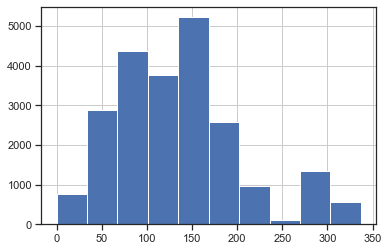

In [8]:
df['num_community_programs'].hist()

<AxesSubplot:xlabel='dispatch_date', ylabel='num_crimes'>

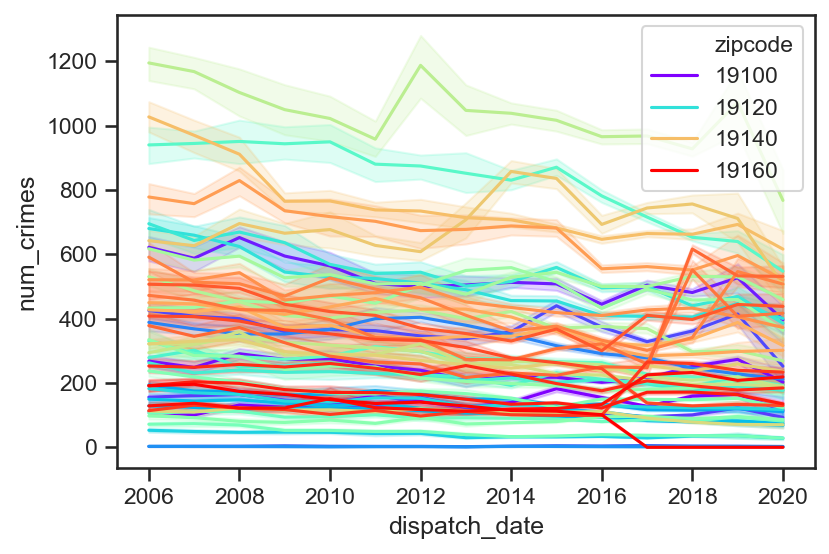

In [15]:
plt.figure(dpi=150)
sns.lineplot(df.dispatch_date.dt.year,df.num_crimes,hue = df.zipcode.astype(str),palette='rainbow')

In [418]:
import folium
import os
import time
from selenium import webdriver


def map_feature_by_zipcode(zipcode_data, col,label,path=None,suffix=None,returnmap=None):
    """
    Generates a folium map of Seattle
    :param zipcode_data: zipcode dataset
    :param col: feature to display
    :return: m
    """

    # read updated geo data
    king_geo = "../datasets/raw_data/Zipcodes_Poly.geojson"
    
    loc = label
    title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)  

    # Initialize Folium Map with Seattle latitude and longitude
    m = folium.Map(location=[40., -75.1652], zoom_start=11,
                   detect_retina=True, control_scale=False)

    # Create choropleth map
    m.choropleth(
        geo_data=king_geo,
        name='choropleth',
        data=zipcode_data,
        # col: feature of interest
        columns=['zipcode', col],
        key_on='feature.properties.CODE',
        fill_color='Blues',
        fill_opacity=0.9,
        line_opacity=0.2,
        #legend_name= label +' '+ col
    )

    #folium.LayerControl().add_to(m)
    m.get_root().html.add_child(folium.Element(title_html))

    # Save map based on feature of interest
    m.save(col + '.html')
    
    #Save the map as an HTML file
    fn='testmap.html'
    tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
    m.save(fn)

    options = webdriver.ChromeOptions()
    options.add_argument("headless")

    #Open a browser window...
    browser = webdriver.Chrome(executable_path='/Users/kessler.363/pythonPrograms/chromedriver',options=options)
    #..that displays the map...
    browser.get(tmpurl)
    #Give the map tiles some time to load
    time.sleep(5)
    #Grab the screenshot
    if path==None:
        browser.save_screenshot(col +'.png')
    else:
        browser.save_screenshot(path+col +suffix+'.png')
    #Close the browser
    browser.quit()
    if returnmap!=None:
        return m


In [419]:
def getsubdf(df,year,col1):
    test = df.groupby([df.zipcode,df['dispatch_date'].dt.to_period('Y')]).sum().reset_index()
    
    test.zipcode = test.zipcode.astype(str)
    test_cut = test[test.dispatch_date.dt.year==year]
    test_cut[col1]=test_cut[col1]/test_cut[col1].max()
    return(test_cut)

In [445]:
path = '../images/community/playstreets/'
test_cut = getsubdf(df,2020,'num_playstreets')
map_feature_by_zipcode(test_cut, 'num_playstreets','Playstreets '+str(year),\
                           path=path,suffix=str(year),returnmap=None)

/Users/kessler.363/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/kessler.363/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [446]:
#'num_housingcouncil', 'num_nac_office', 'num_nac', 'year', 'num_pools',
# 'num_spraygrounds', 'num_playstreets', 'num_playgrounds', 'num_crimes',
path = '../images/community/pools/'
years = np.arange(2006,2021,1)
for year in years:
    test_cut = getsubdf(df,year,'num_pools')
    map_feature_by_zipcode(test_cut, 'num_pools','Pools '+str(year),\
                           path=path,suffix=str(year),returnmap=None)
    
    

/Users/kessler.363/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/kessler.363/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
/Users/kessler.363/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

/Users/kessler.363/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/kessler.363/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
/Users/kessler.363/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [451]:
from glob import glob
filenames = sorted(glob(path+'*'))

In [452]:
import imageio
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave(path+'pools_dt.gif', images,duration=0.5)

In [453]:
decrim_weed = pd.to_datetime(20141020, format='%Y%m%d', errors='ignore')
decrim_weed
#('13000101', format='%Y%m%d', errors='ignore')
#2014-10-20

Timestamp('2014-10-20 00:00:00')

In [354]:
plt.figure(dpi=150)
plt.

In [438]:
df.groupby([df.zipcode,df['dispatch_date'].dt.to_period('Y')]).sum().reset_index()

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
       ...  
715      0.0
716      0.0
717    720.0
718      0.0
719      0.0
Name: num_playgrounds, Length: 720, dtype: float64

<AxesSubplot:xlabel='dispatch_date', ylabel='num_spraygrounds'>

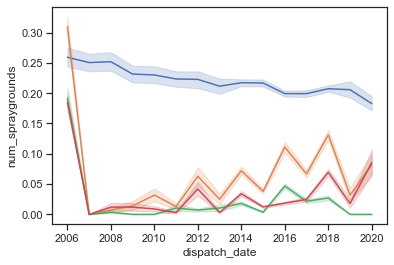

In [85]:
sns.lineplot(x=df.dispatch_date.dt.year,y=df.num_crimes/df.num_crimes.max())
sns.lineplot(x=df.dispatch_date.dt.year,y=df.num_playgrounds/df.num_playgrounds.max())
sns.lineplot(x=df.dispatch_date.dt.year,y=df.num_pools/df.num_pools.max())
sns.lineplot(x=df.dispatch_date.dt.year,y=df.num_spraygrounds/df.num_spraygrounds.max())


In [78]:
test = df[['zipcode', 'dispatch_date','num_art', 'num_fm', 'num_parks', 'num_landmark',
       'num_housingcouncil', 'num_nac_office','num_pools',
       'num_spraygrounds', 'num_playstreets', 'num_playgrounds', 'text_general_code_Burglary']]
#zips = pd.get_dummies(test.zipcode)
test = test.drop(['zipcode', 'dispatch_date'],axis=1)
#test = test.join(zips)
test

num_art  num_fm  num_parks  num_landmark  num_housingcouncil  \
0          0.0     0.0        1.0          33.0                 1.0   
1          0.0     0.0        1.0          33.0                 1.0   
2          0.0     0.0        1.0          33.0                 1.0   
3          0.0     0.0        1.0          33.0                 1.0   
4          0.0     0.0        1.0          33.0                 1.0   
...        ...     ...        ...           ...                 ...   
22577      0.0     0.0       14.0         136.0                 0.0   
22578      0.0     0.0       14.0         136.0                 0.0   
22579      0.0     0.0       14.0         136.0                 0.0   
22580      0.0     0.0       14.0         136.0                 0.0   
22581      0.0     0.0       14.0         136.0                 0.0   

       num_nac_office  num_pools  num_spraygrounds  num_playstreets  \
0                 0.0        0.0               0.0              0.0   
1                 0.0        0.0               0.0              0.0   
2                 0.0        0.0               0.0              0.0   
3                 0.0        0.0               0.0              0.0   
4                 0.0        0.0               0.0              0.0   
...               ...        ...               ...              ...   
22577             0.0        0.0               0.0              0.0   
22578             0.0        0.0               0.0              0.0   
22579             0.0        0.0               0.0              0.0   
22580             0.0        0.0               0.0              0.0   
22581             0.0        0.0               0.0              0.0   

       num_playgrounds  text_general_code_Burglary  
0                  0.0                         238  
1                  0.0                         186  
2                  0.0                         252  
3                  0.0                         248  
4                  0.0                         210  
...                ...                         ...  
22577              0.0                         150  
22578              0.0                         200  
22579              0.0                         218  
22580              0.0                         242  
22581              0.0                         132  

[22582 rows x 11 columns]

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso


from sklearn.linear_model import LassoCV

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [80]:
x = test.drop('text_general_code_Burglary',axis=1)
y=test['text_general_code_Burglary']

In [81]:
train_x,test_x,train_y,test_y = train_test_split(x,y,test_size=0.3,random_state=609)

In [82]:
alpha=0.1
lasso_pipe = Pipeline([('scale',StandardScaler()),
                          ('lasso',Lasso(alpha=alpha,normalize=False, random_state=609, max_iter=1e6,
                                          fit_intercept=False))])

lasso_pipe.fit(train_x,train_y)

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lasso',
                 Lasso(alpha=0.1, copy_X=True, fit_intercept=False,
                       max_iter=1000000.0, normalize=False, positive=False,
                       precompute=False, random_state=609, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

In [83]:
lasso_pipe.score(train_x,train_y)

-1.3943639980294162

<AxesSubplot:>

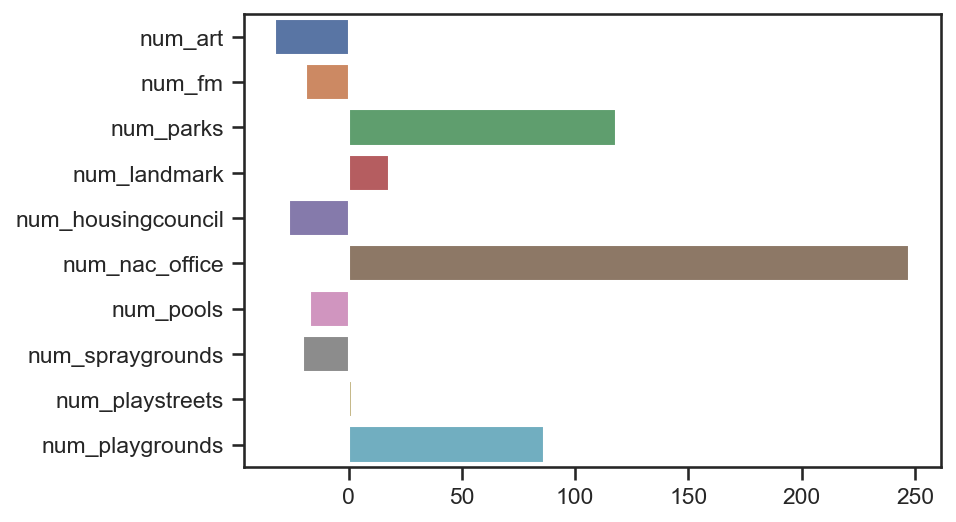

In [84]:
plt.figure(dpi=150)
sns.barplot(x=lasso_pipe['lasso'].coef_, y=train_x.columns)

In [4]:
import fbprophet

In [5]:
crime = df[['dispatch_date','num_crimes']]
crime = crime.rename(columns={'dispatch_date':'ds','num_crimes':'y'})

In [14]:
crime_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
crime_prophet.fit(crime[~crime.isna()])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [15]:
crime_forecast = crime_prophet.make_future_dataframe(periods=12 * 2, freq='M')
crime_forecast = crime_prophet.predict(crime_forecast)

Text(0.5, 1.0, 'Crimes in Philadelphia')

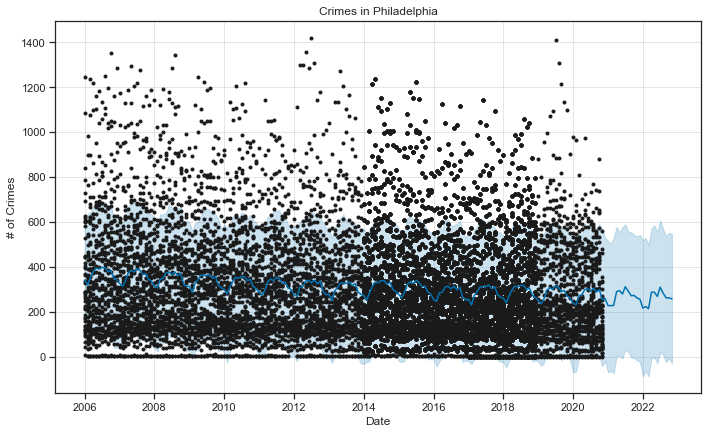

In [16]:
crime_prophet.plot(crime_forecast, xlabel = 'Date', ylabel = '# of Crimes')
plt.title('Crimes in Philadelphia')

In [17]:
from fbprophet.plot import plot
zipcodes = df.zipcode.unique()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

<Figure size 900x600 with 0 Axes>

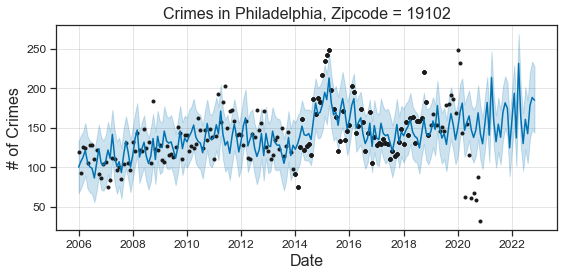

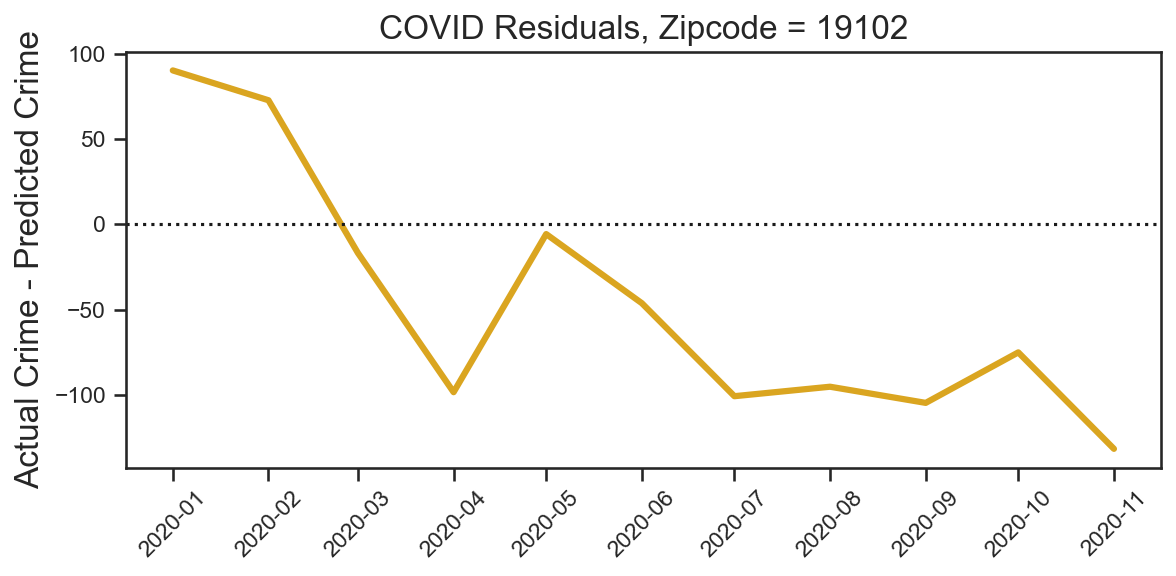

<Figure size 900x600 with 0 Axes>

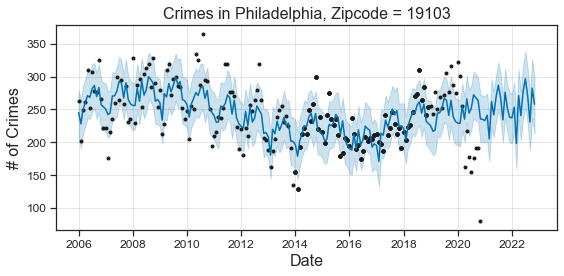

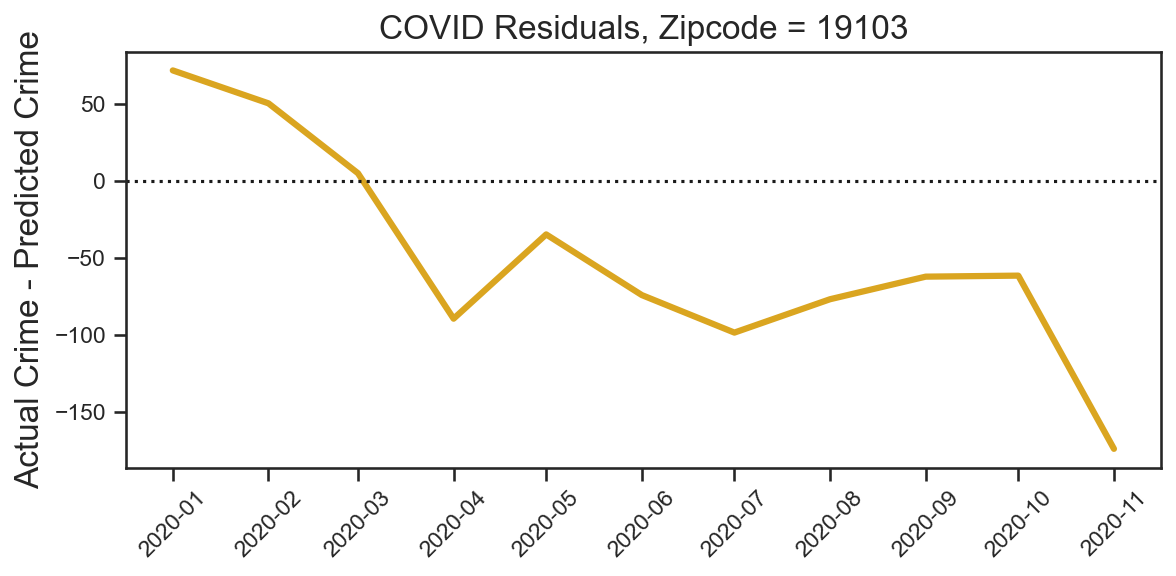

<Figure size 900x600 with 0 Axes>

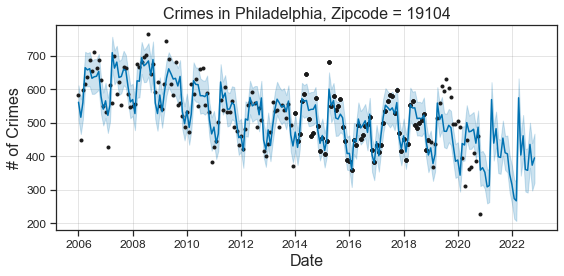

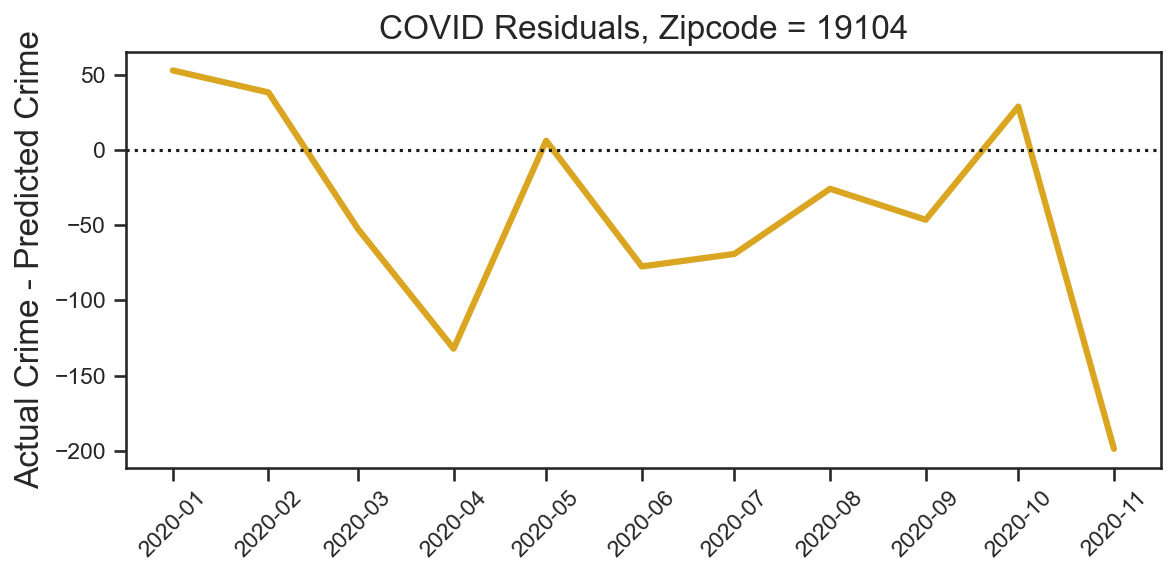

<Figure size 900x600 with 0 Axes>

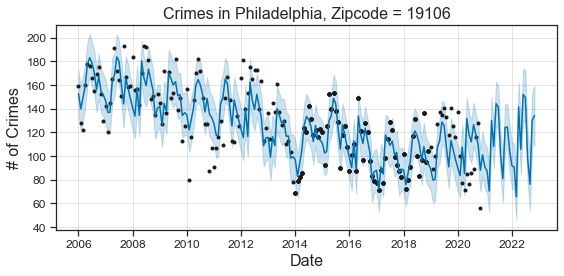

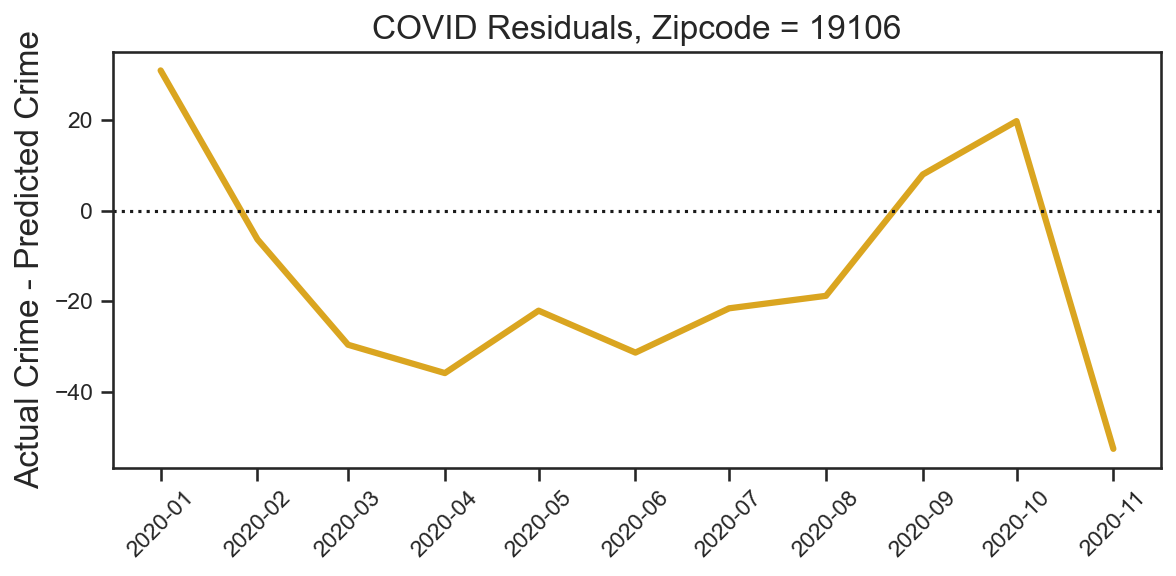

<Figure size 900x600 with 0 Axes>

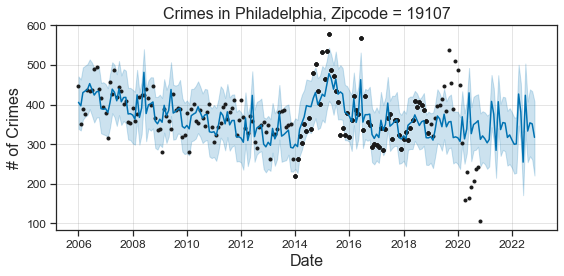

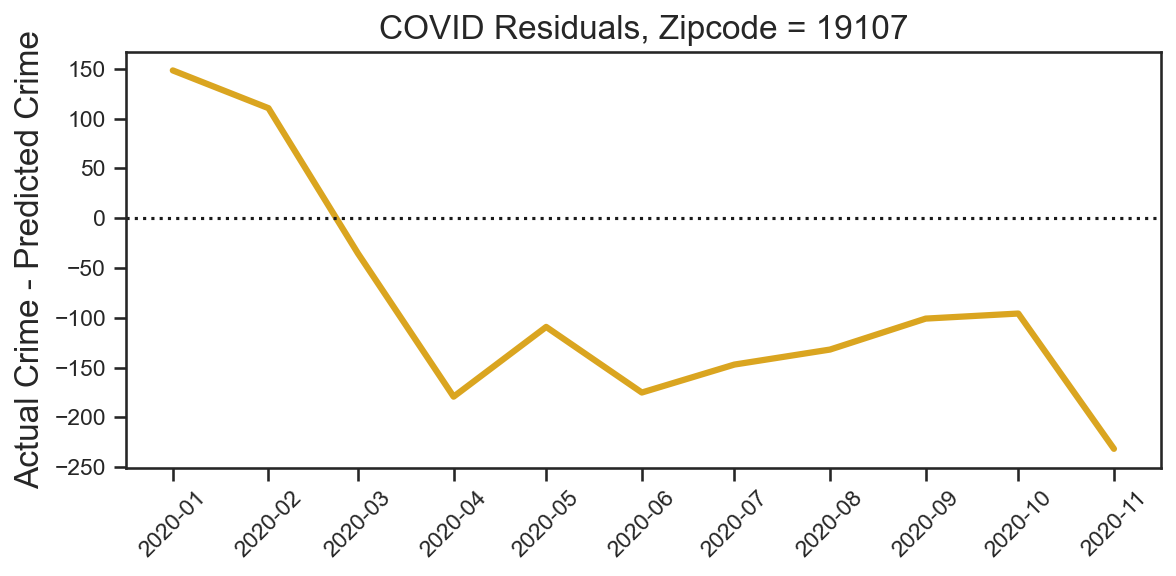

<Figure size 900x600 with 0 Axes>

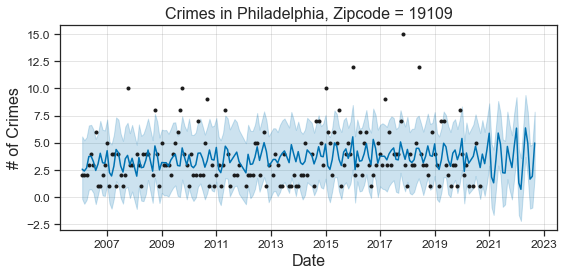

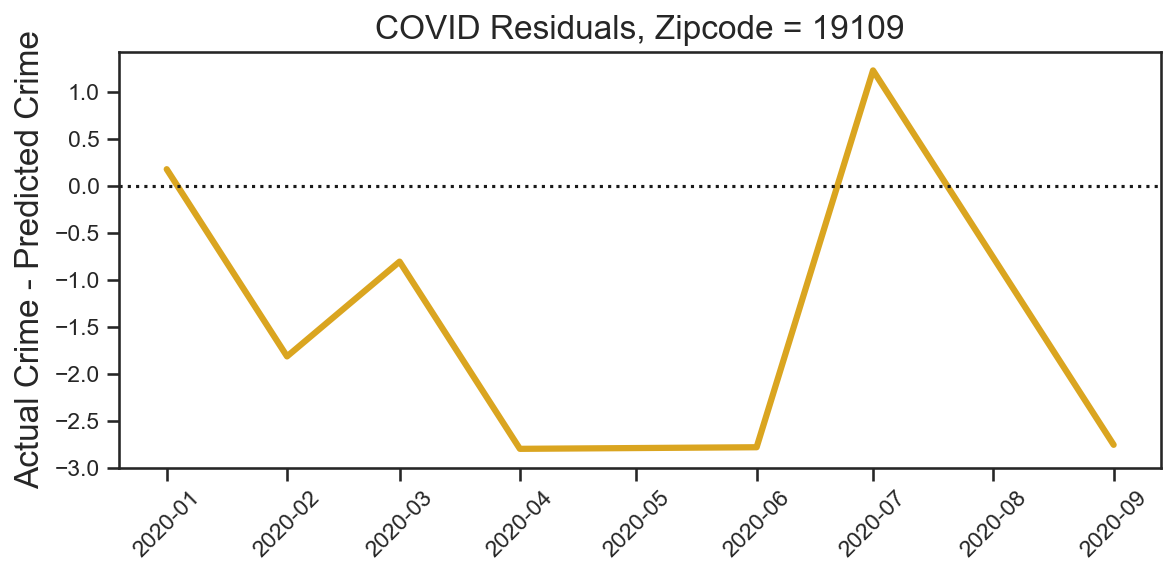

<Figure size 900x600 with 0 Axes>

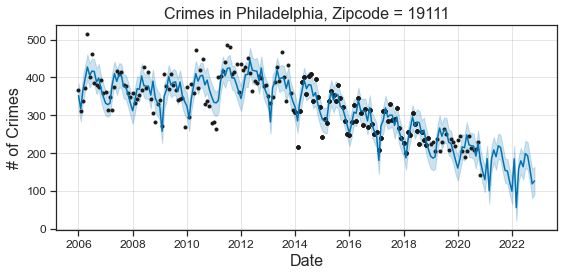

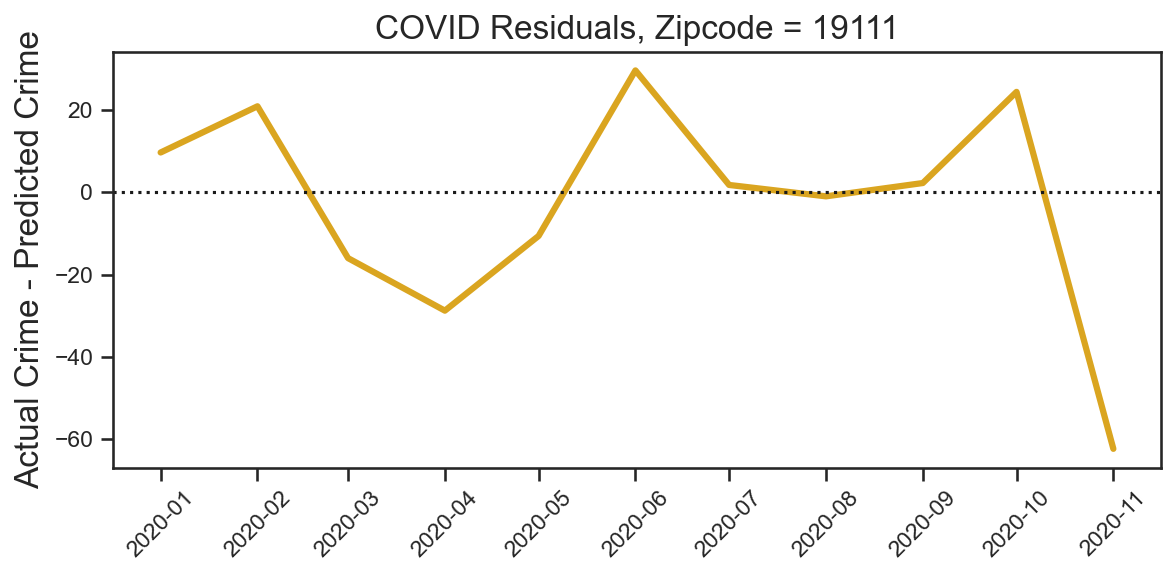

<Figure size 900x600 with 0 Axes>

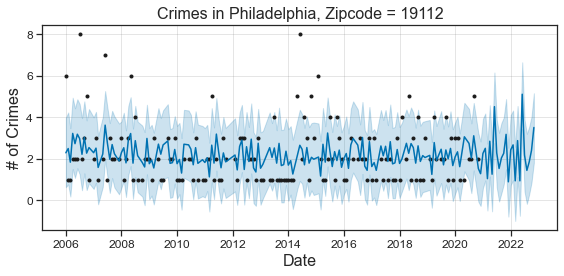

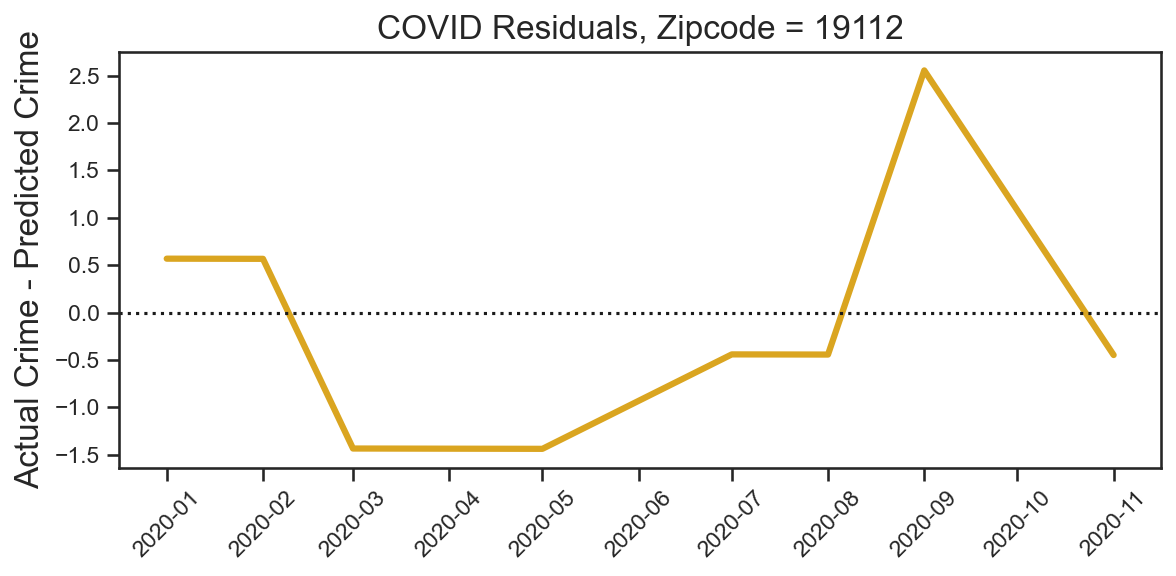

<Figure size 900x600 with 0 Axes>

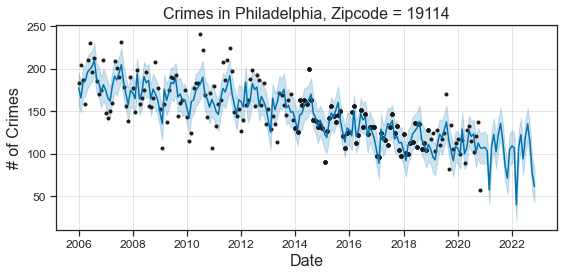

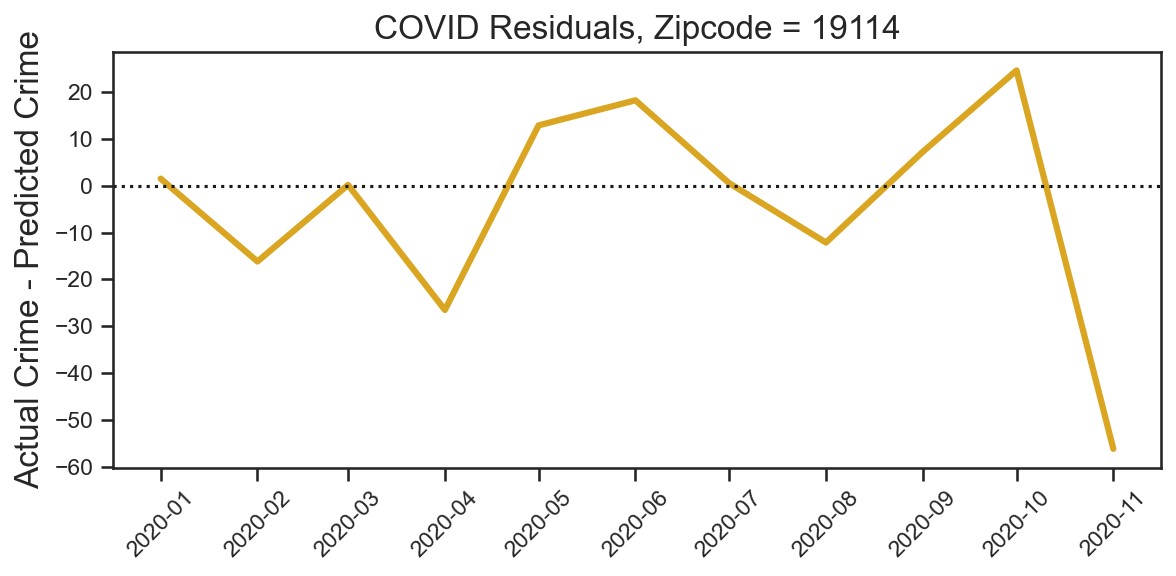

<Figure size 900x600 with 0 Axes>

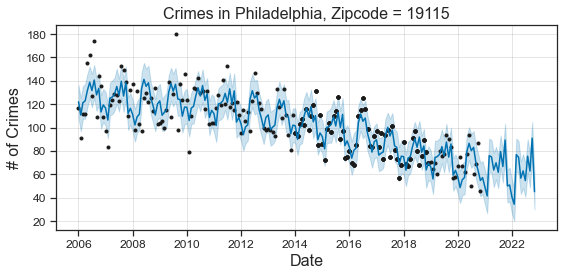

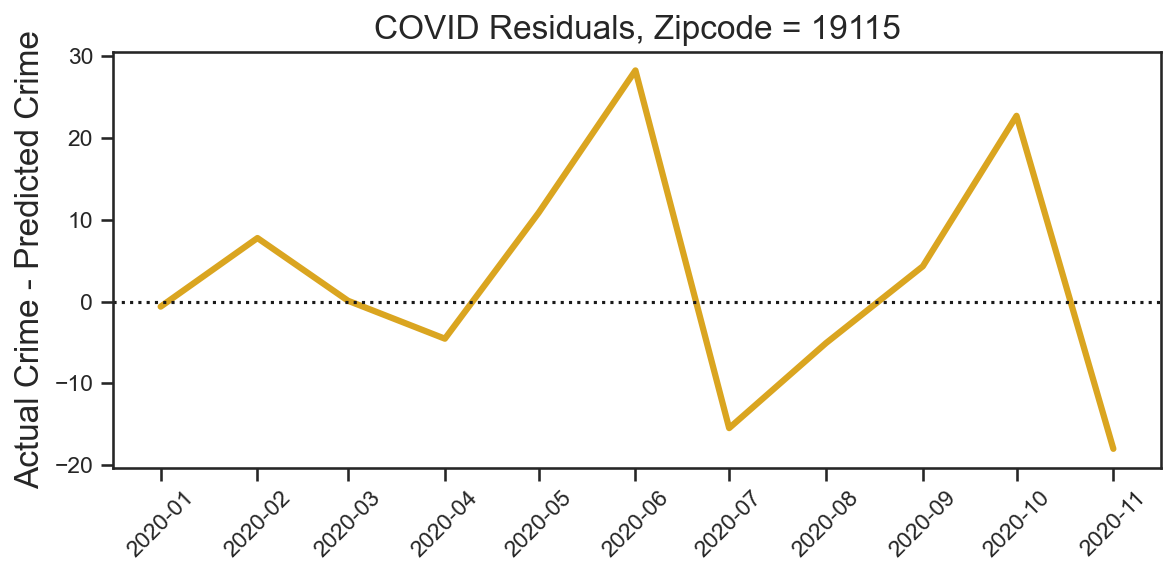

<Figure size 900x600 with 0 Axes>

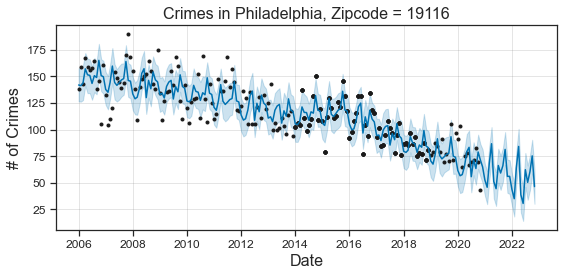

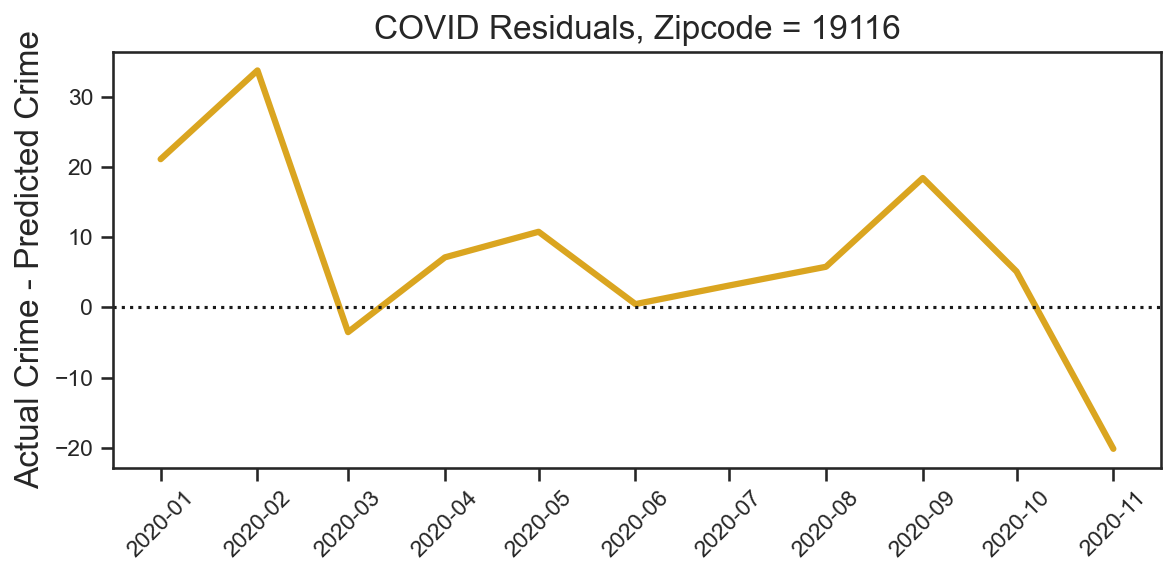

<Figure size 900x600 with 0 Axes>

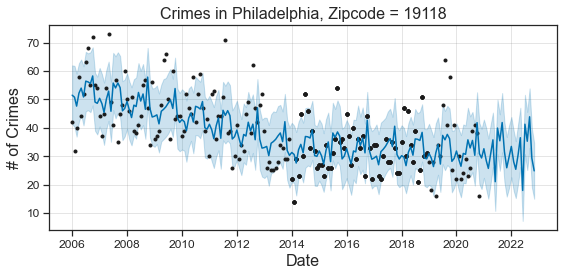

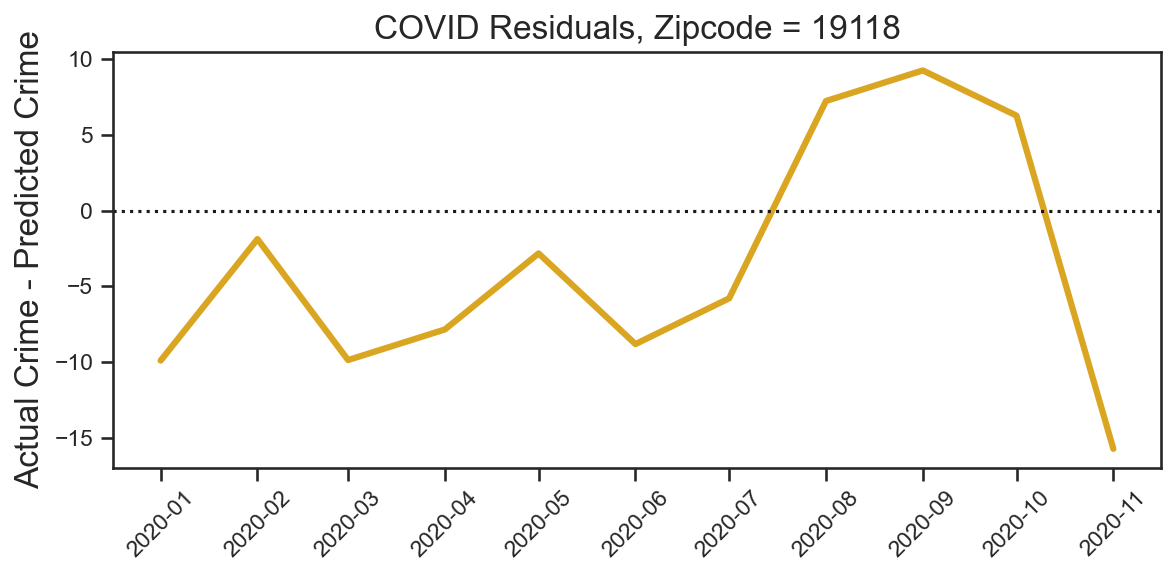

<Figure size 900x600 with 0 Axes>

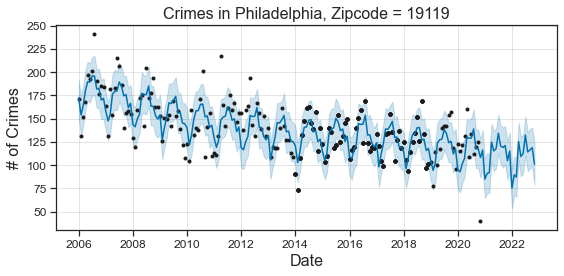

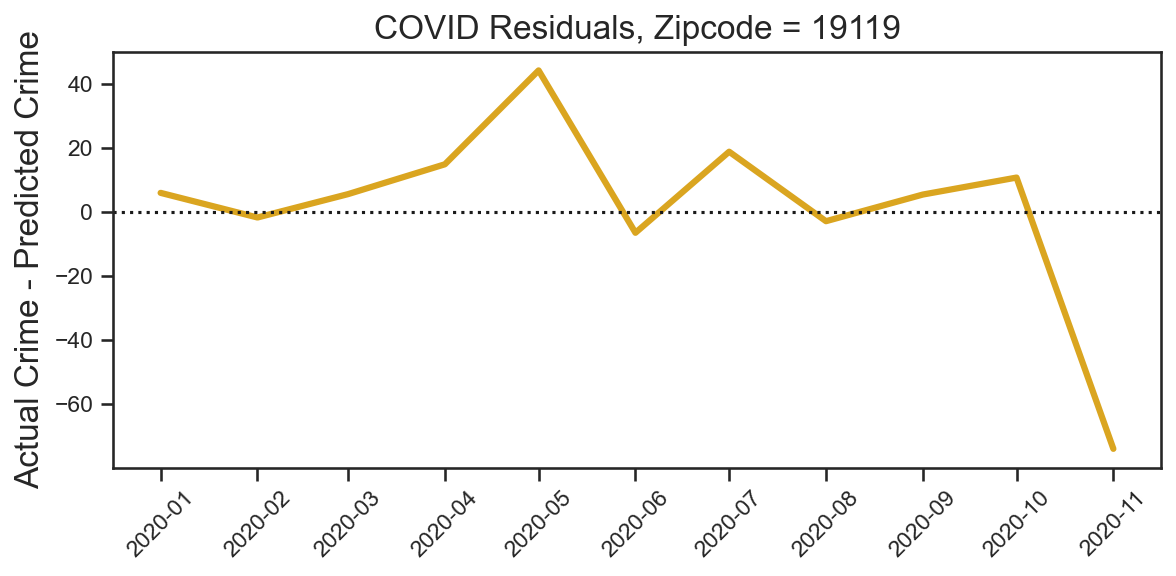

<Figure size 900x600 with 0 Axes>

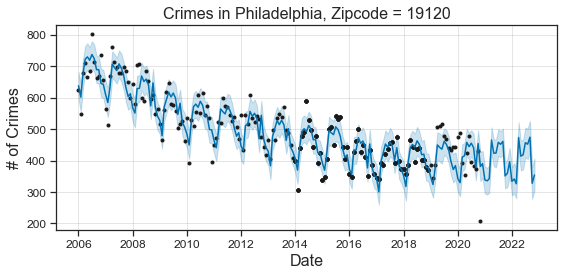

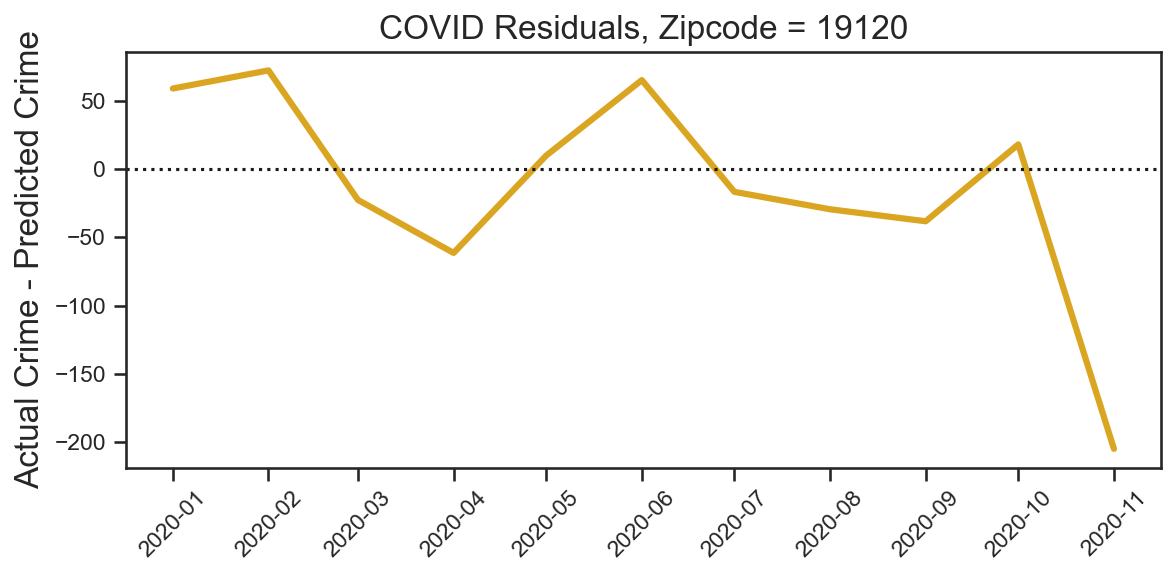

<Figure size 900x600 with 0 Axes>

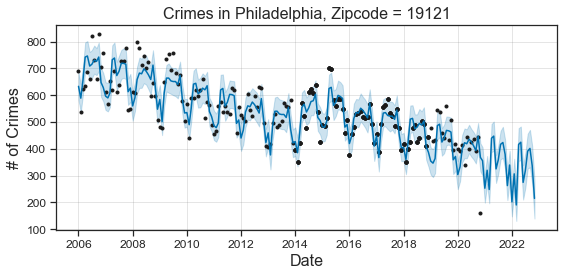

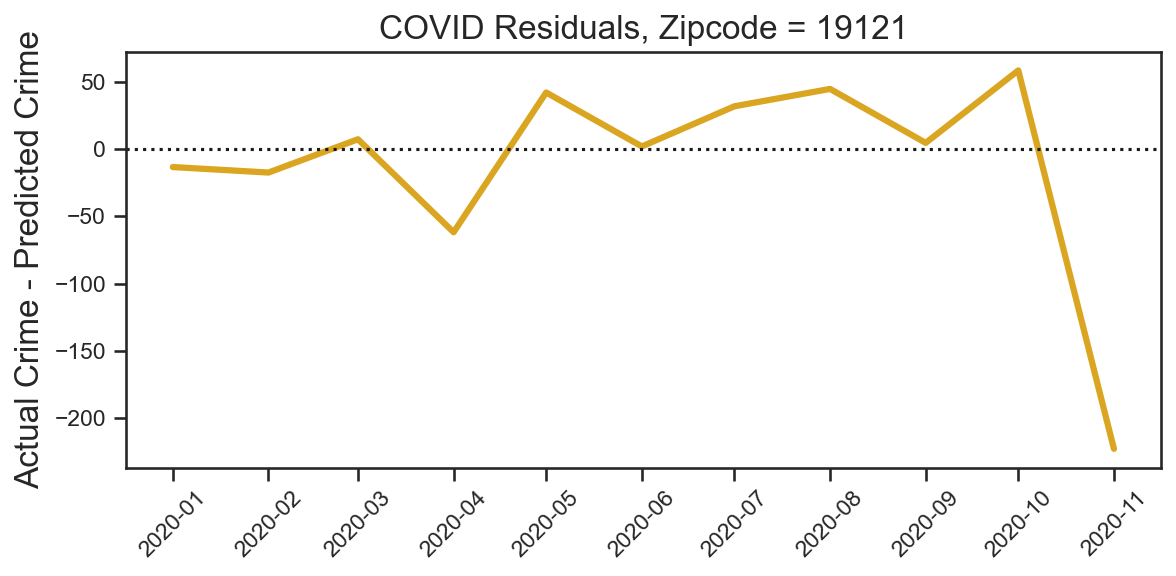

<Figure size 900x600 with 0 Axes>

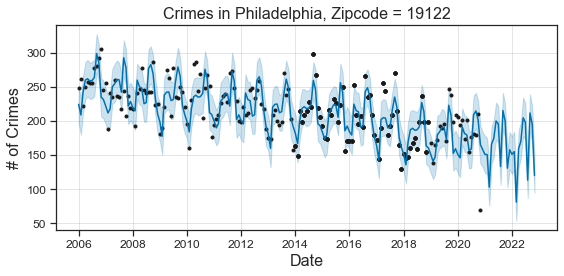

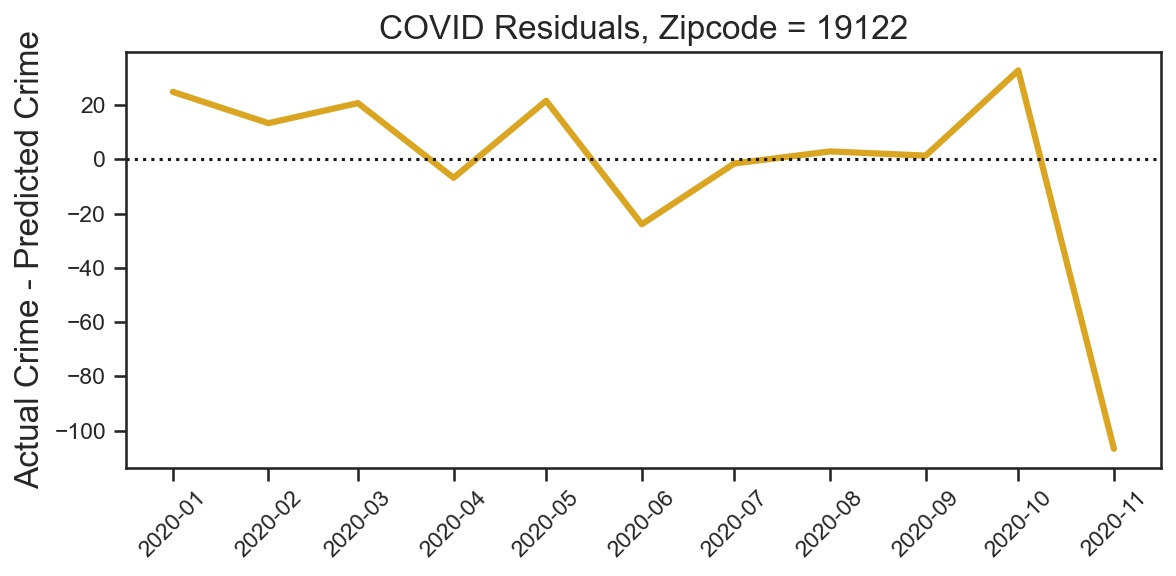

<Figure size 900x600 with 0 Axes>

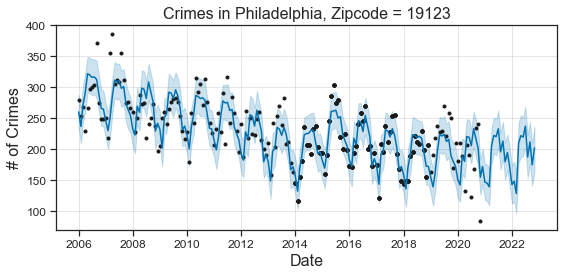

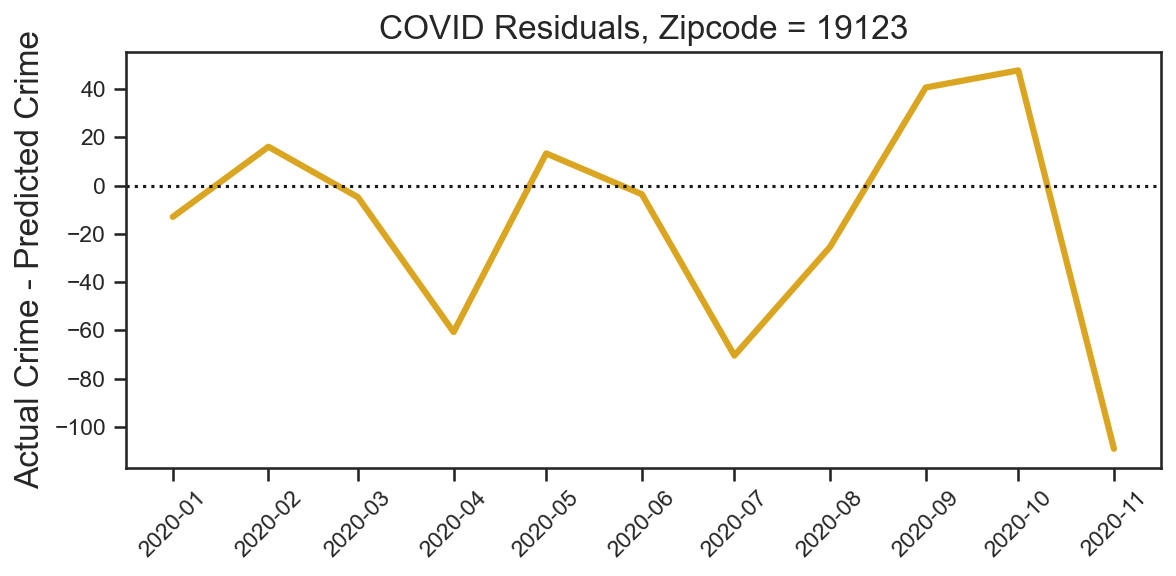

<Figure size 900x600 with 0 Axes>

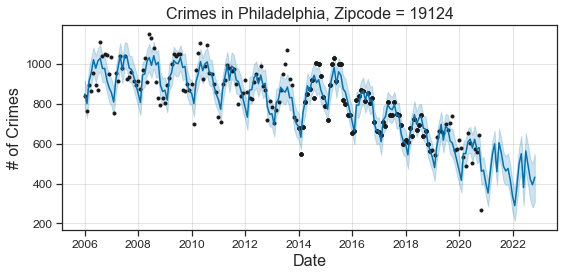

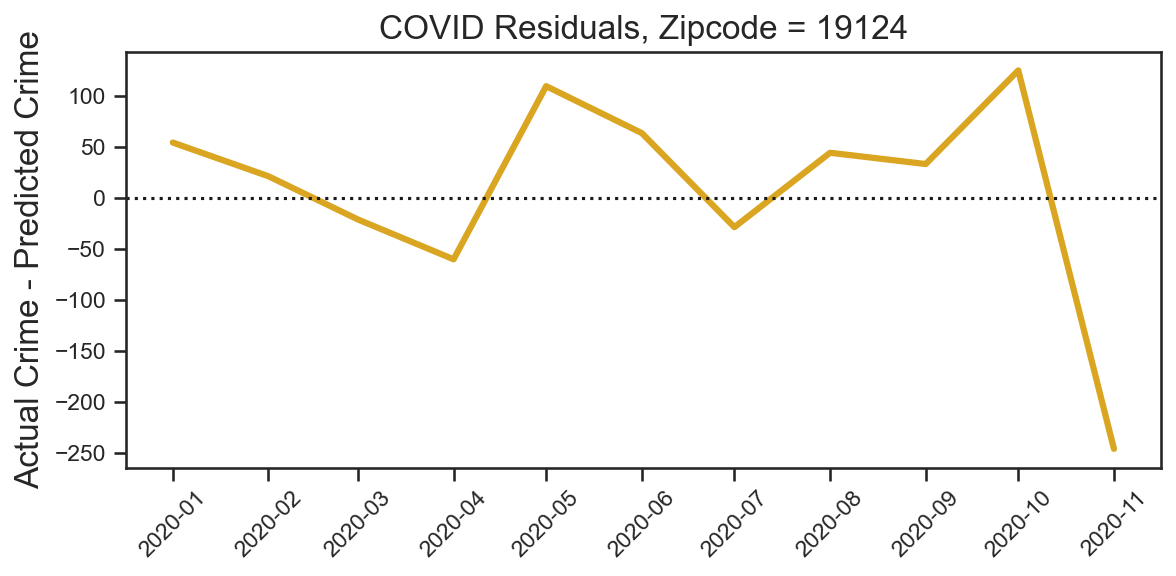

<Figure size 900x600 with 0 Axes>

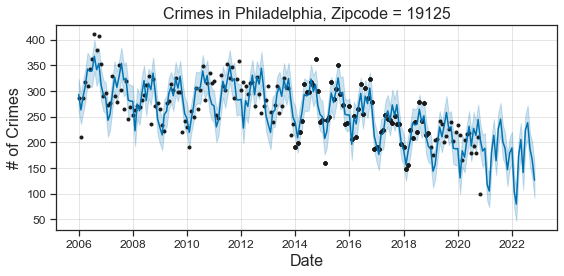

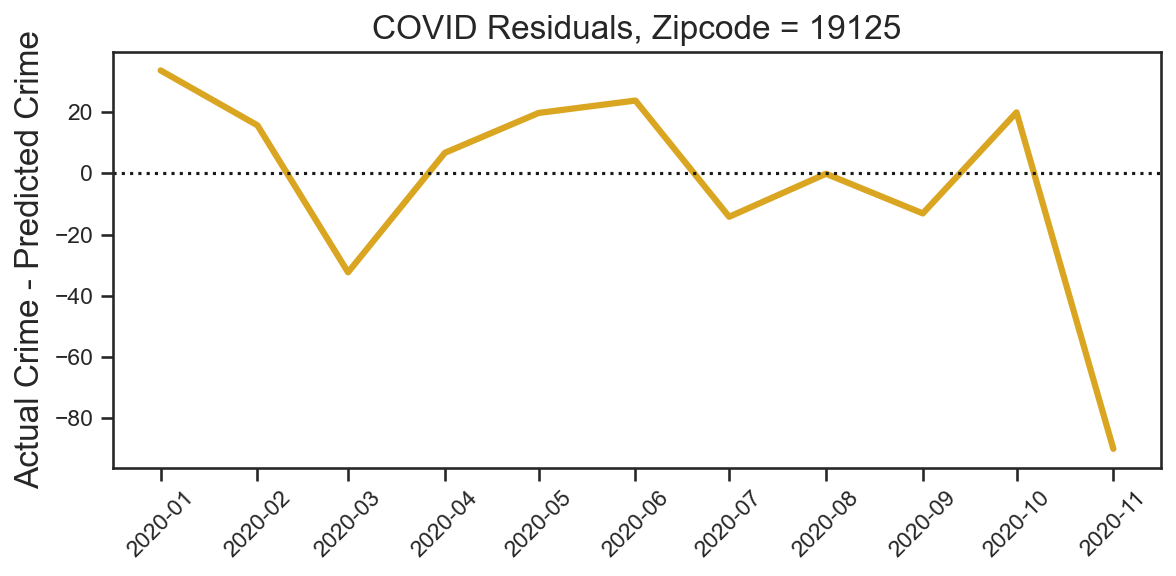

<Figure size 900x600 with 0 Axes>

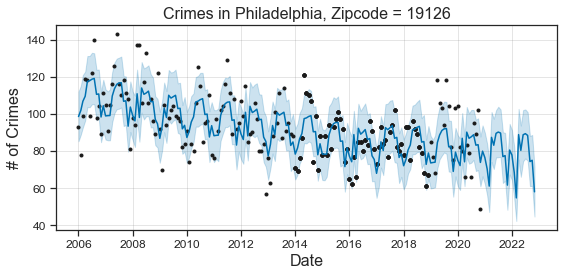

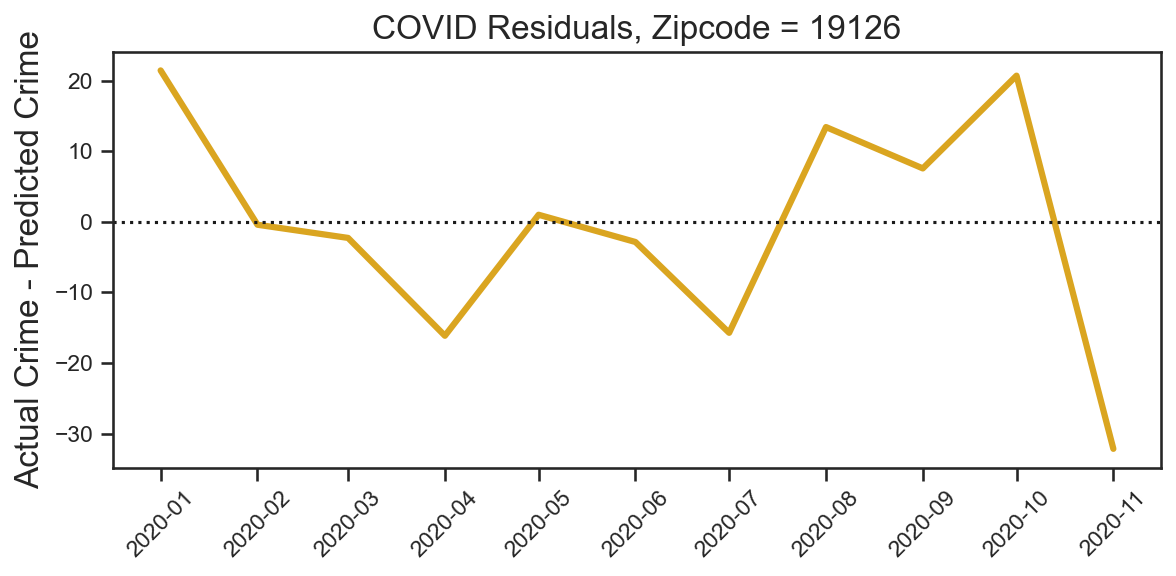

<Figure size 900x600 with 0 Axes>

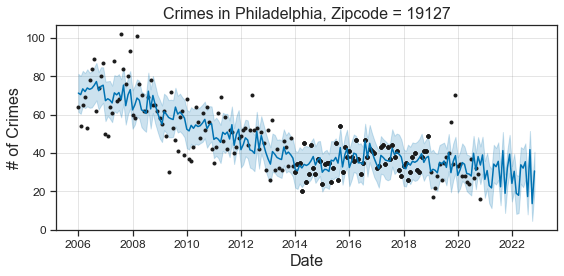

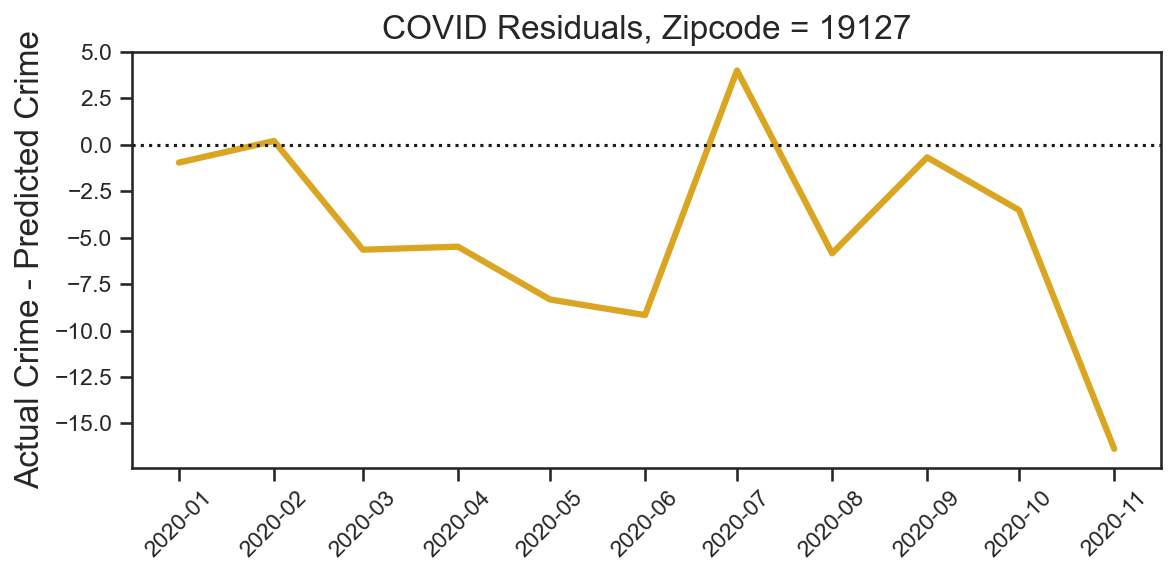

<Figure size 900x600 with 0 Axes>

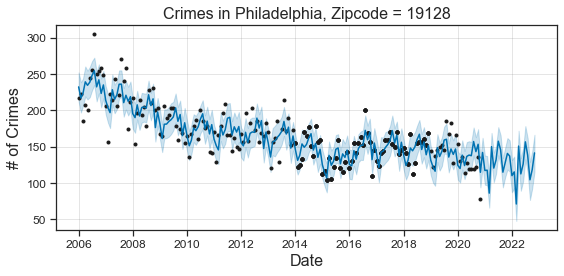

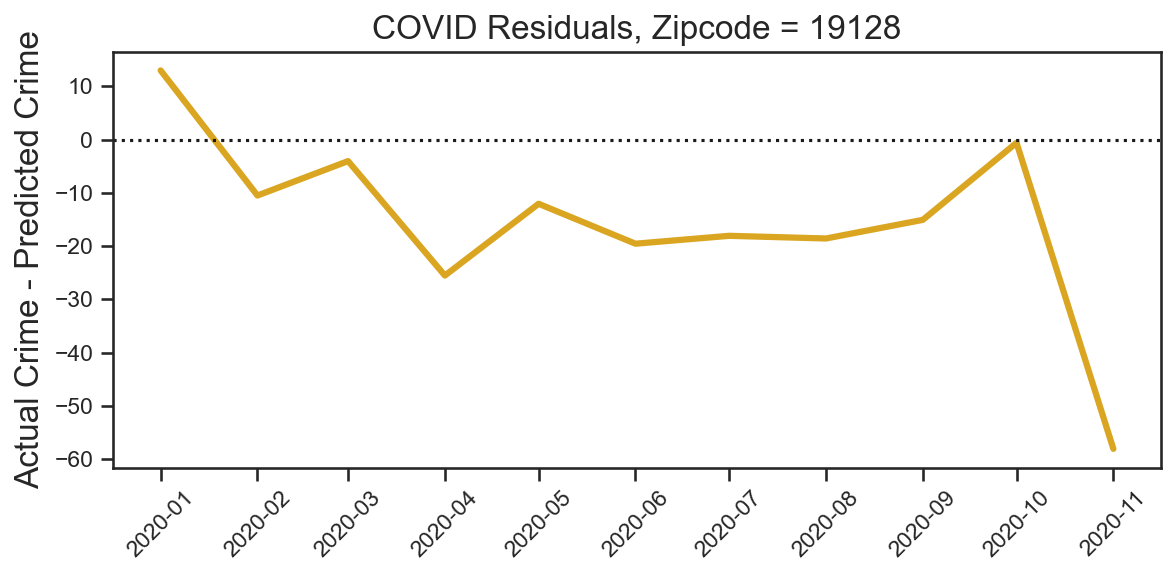

<Figure size 900x600 with 0 Axes>

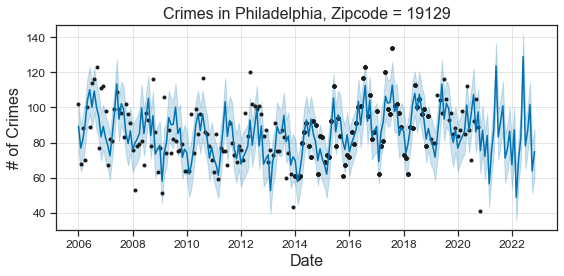

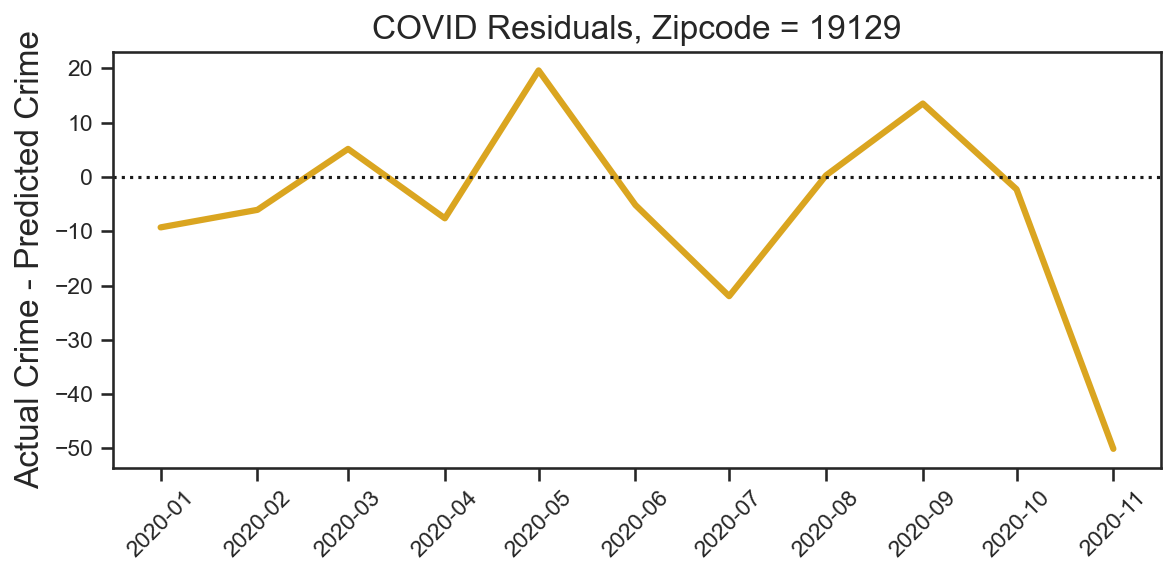

<Figure size 900x600 with 0 Axes>

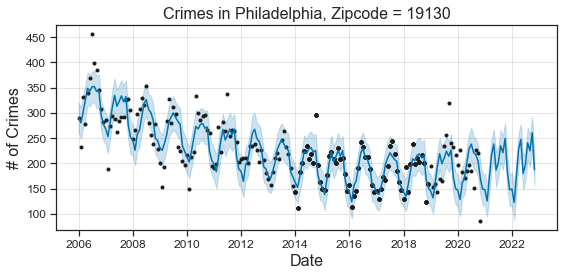

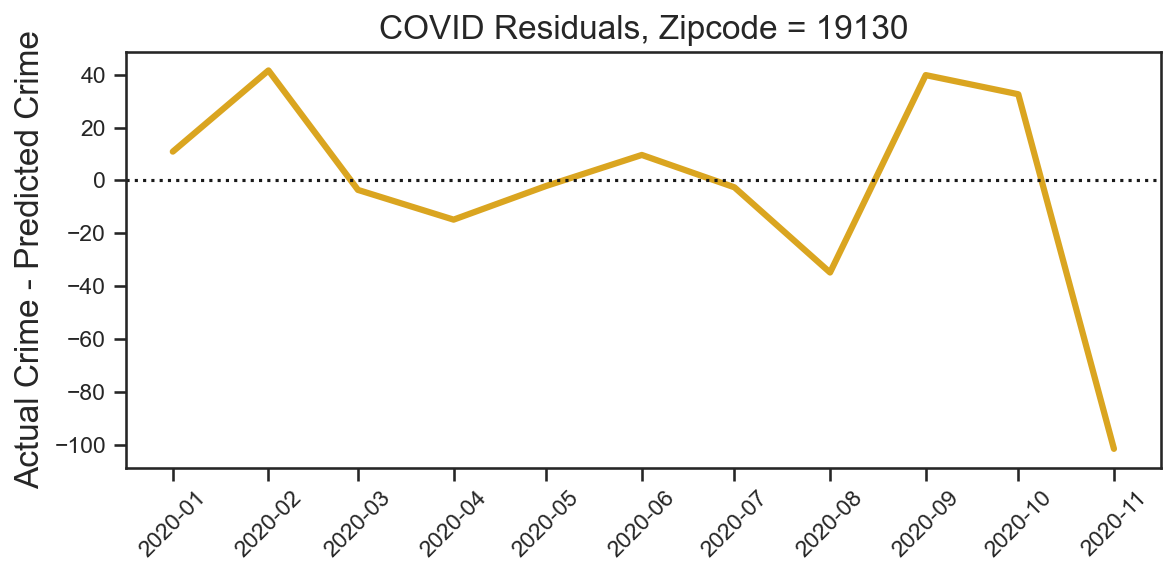

<Figure size 900x600 with 0 Axes>

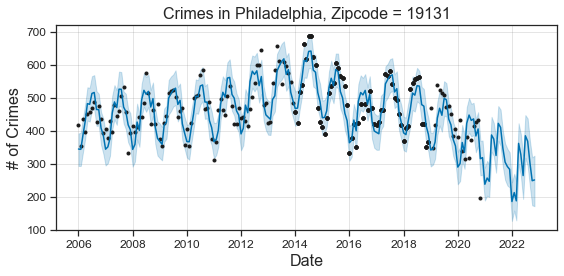

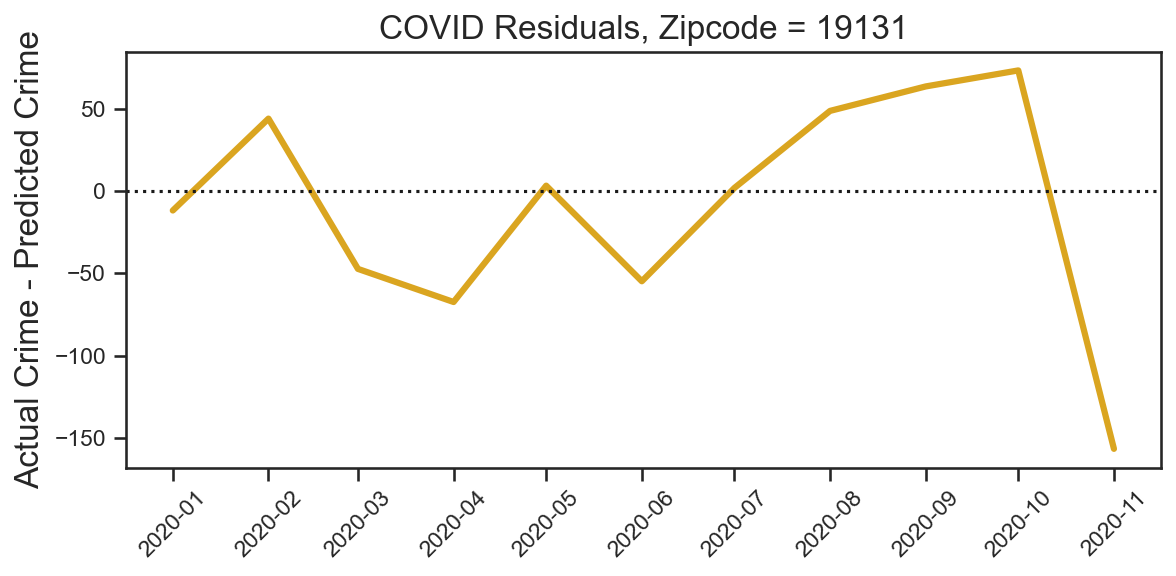

<Figure size 900x600 with 0 Axes>

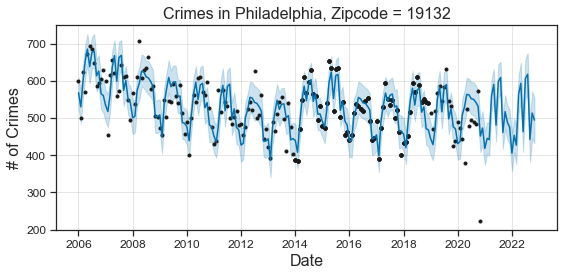

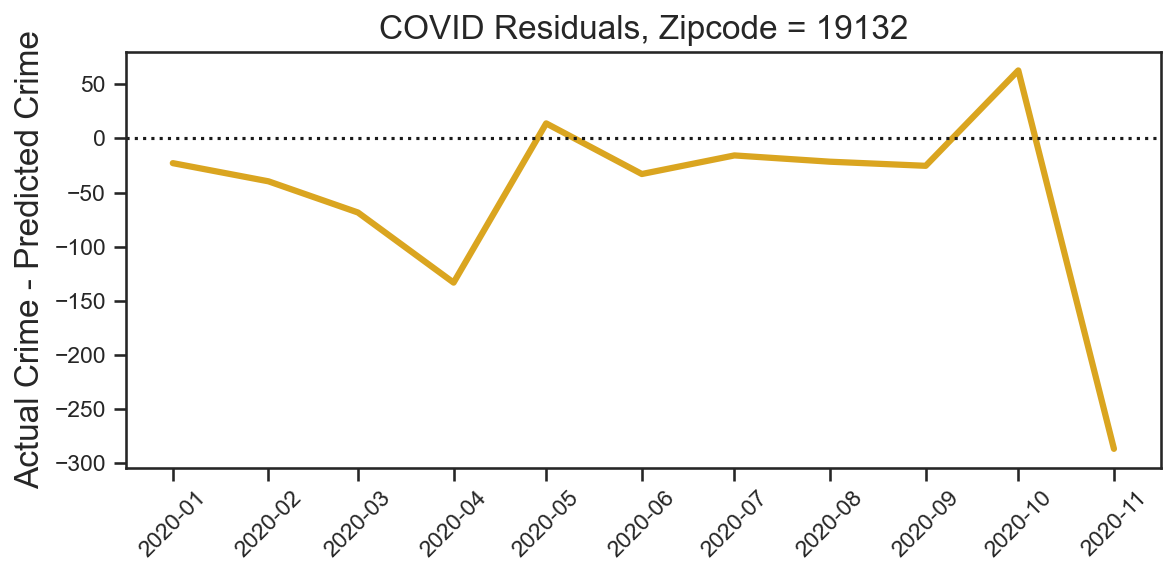

<Figure size 900x600 with 0 Axes>

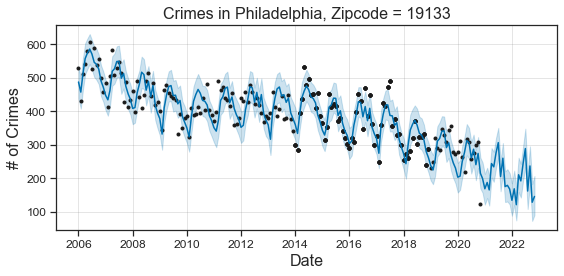

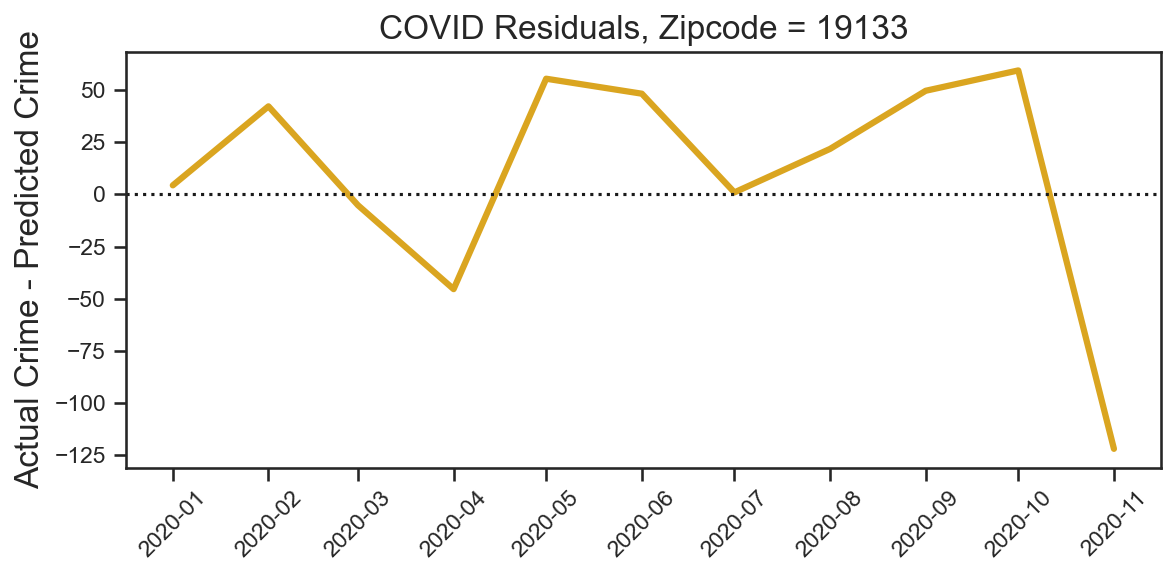

<Figure size 900x600 with 0 Axes>

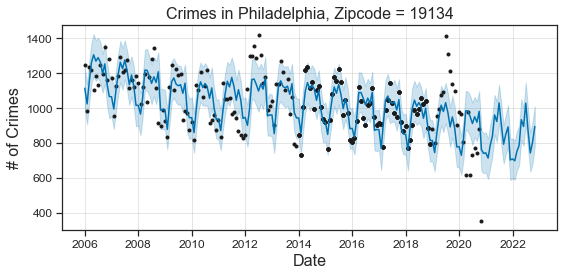

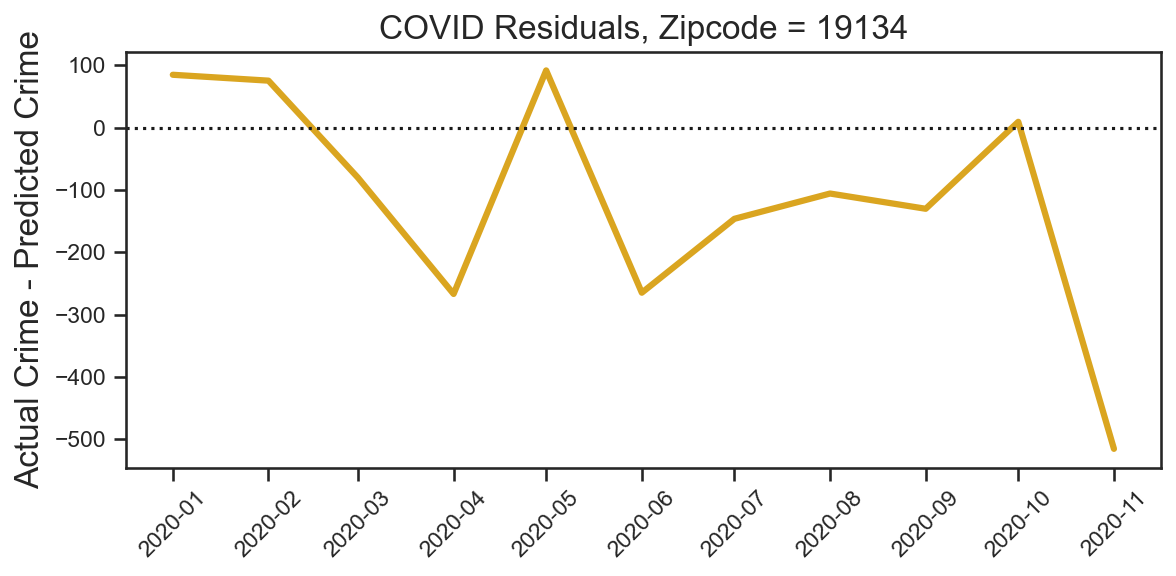

<Figure size 900x600 with 0 Axes>

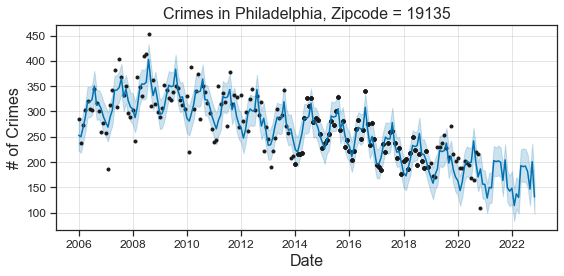

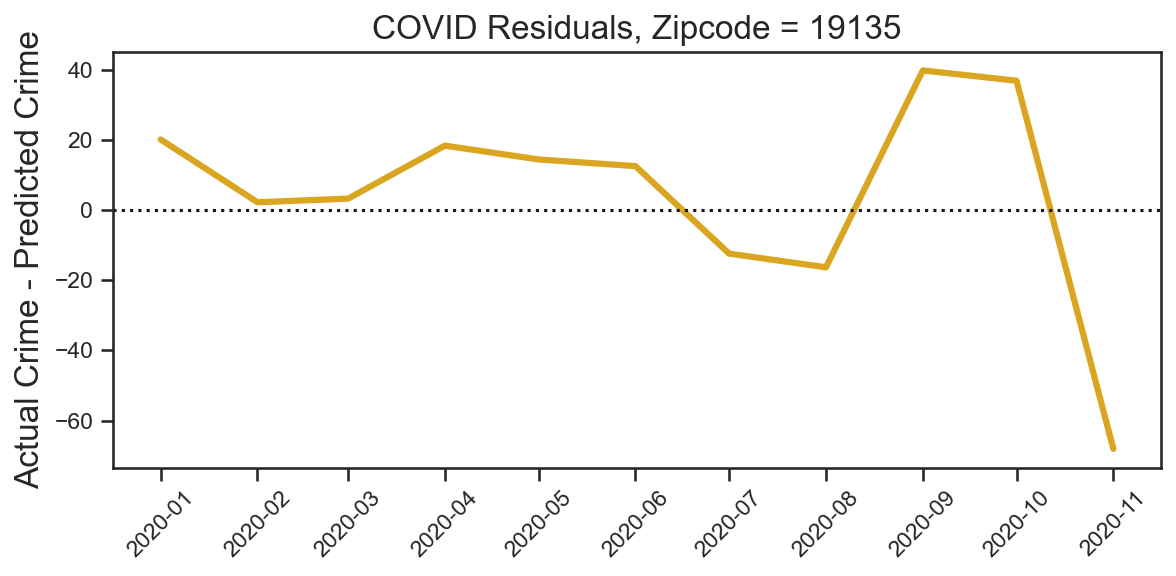

<Figure size 900x600 with 0 Axes>

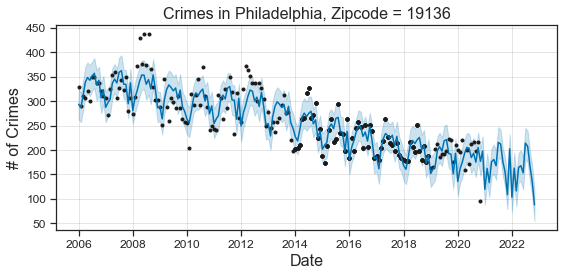

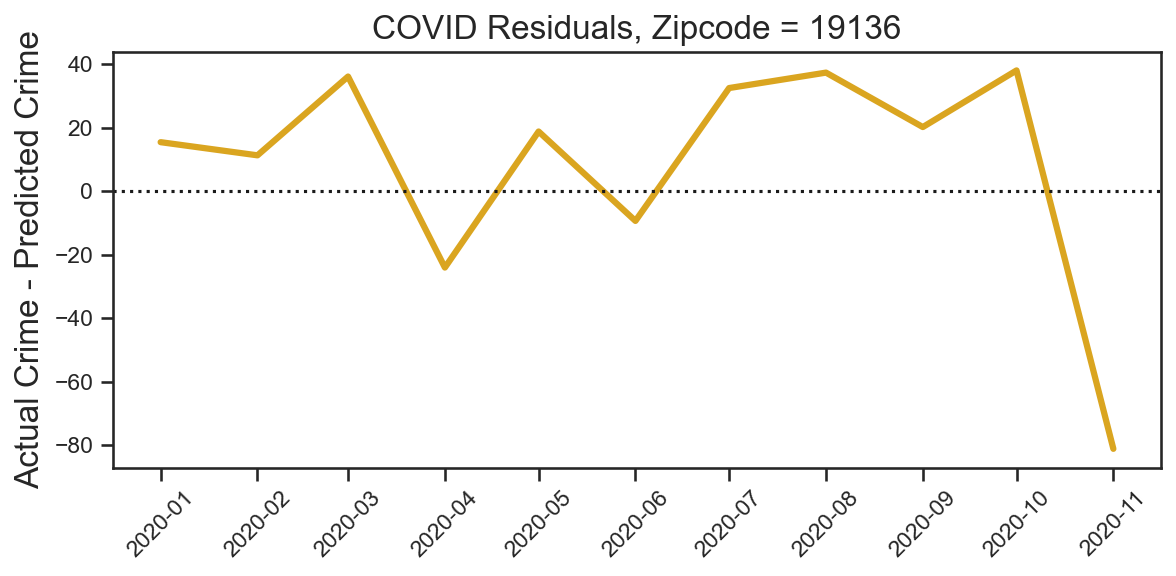

<Figure size 900x600 with 0 Axes>

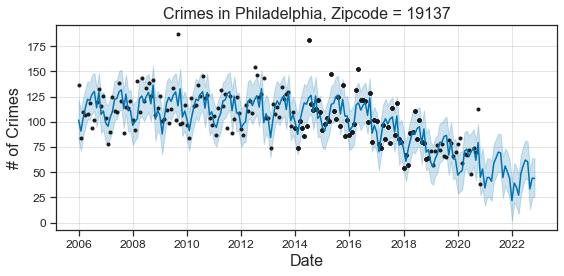

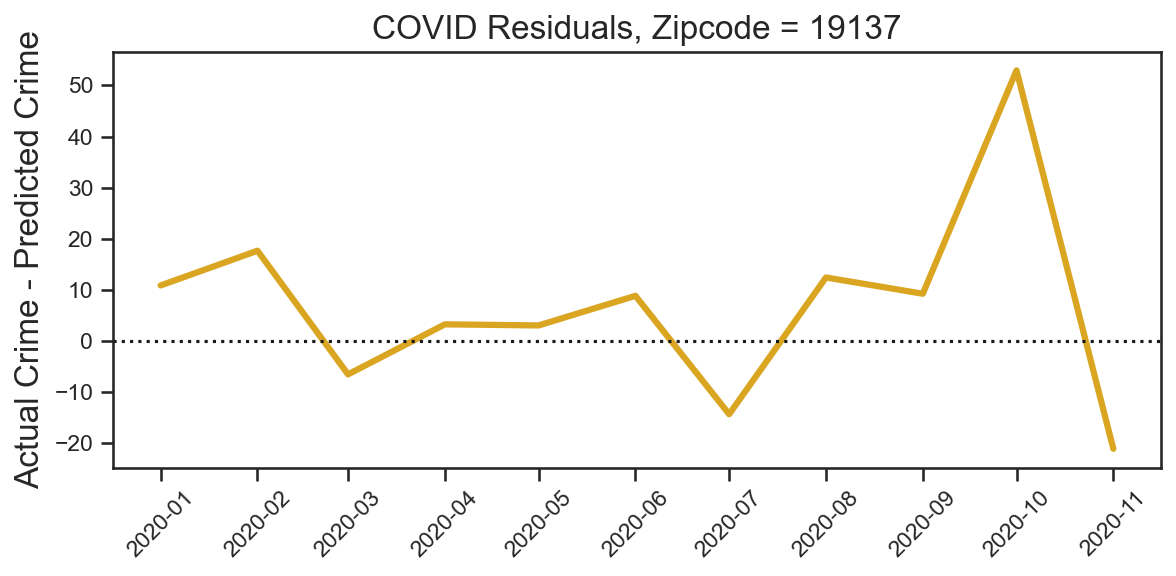

<Figure size 900x600 with 0 Axes>

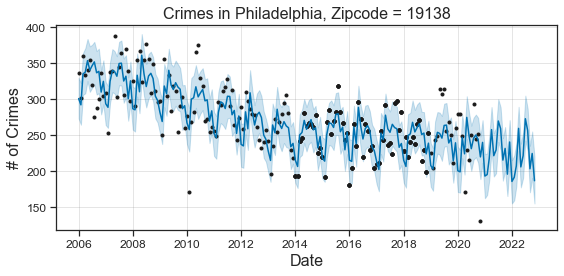

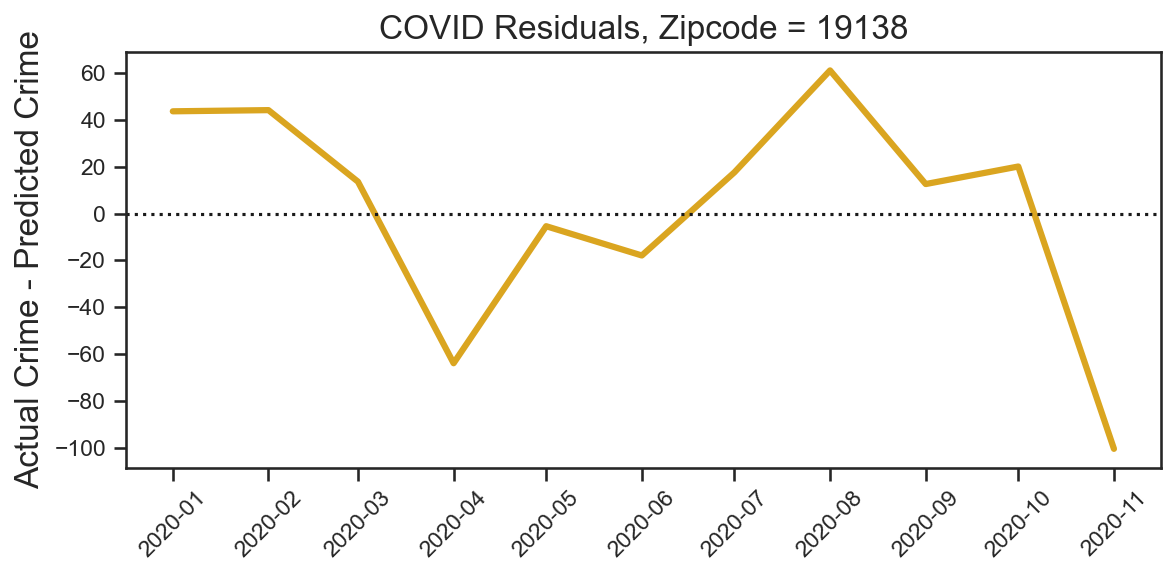

<Figure size 900x600 with 0 Axes>

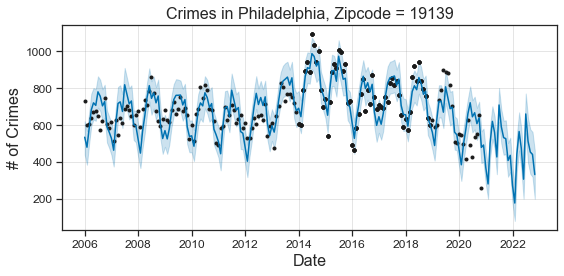

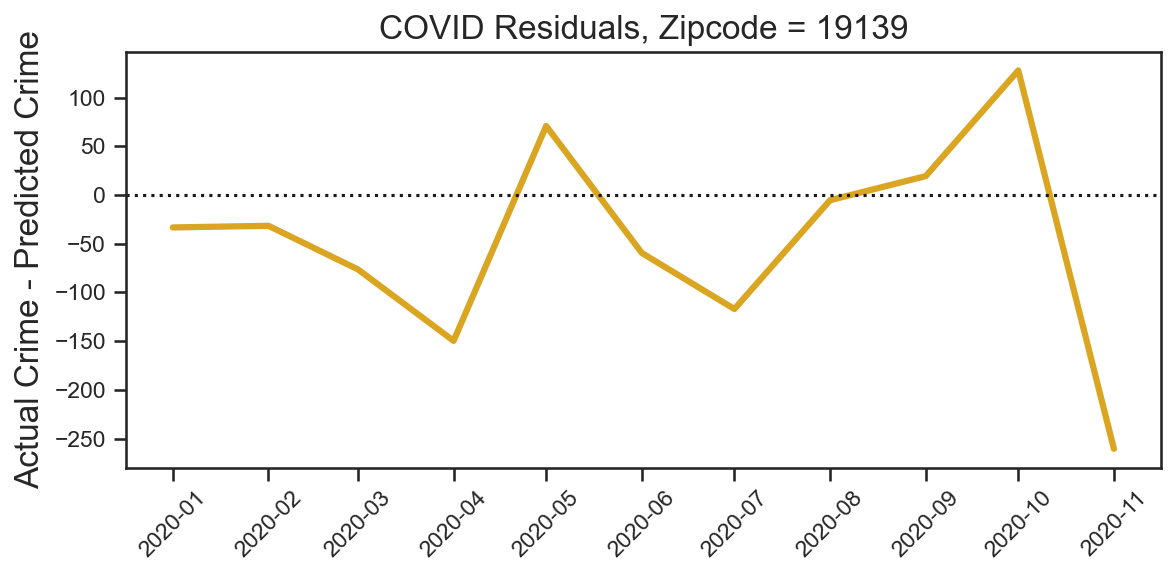

<Figure size 900x600 with 0 Axes>

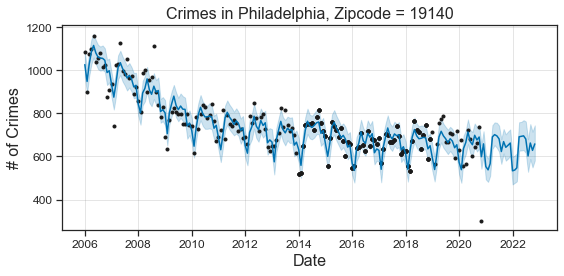

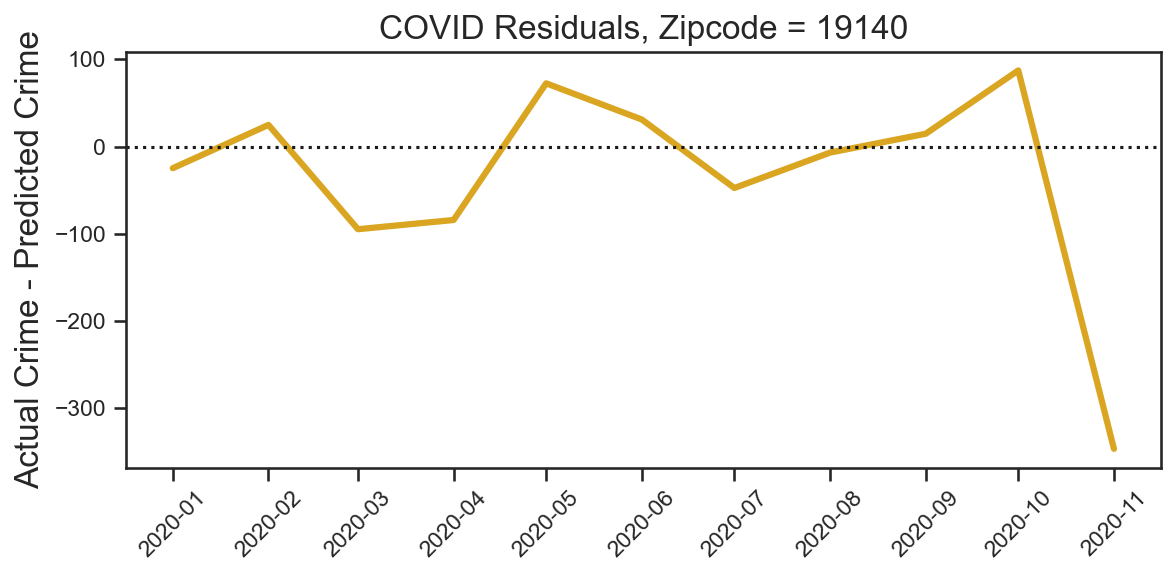

<Figure size 900x600 with 0 Axes>

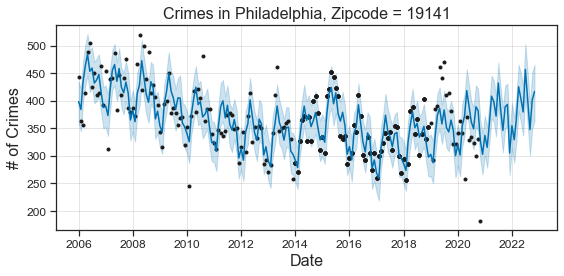

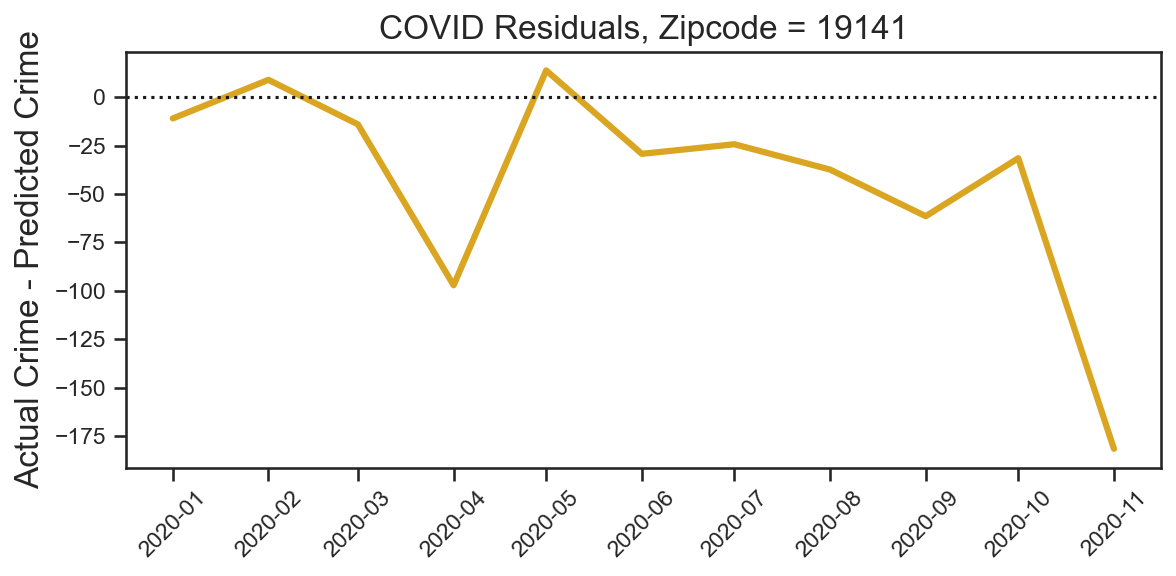

<Figure size 900x600 with 0 Axes>

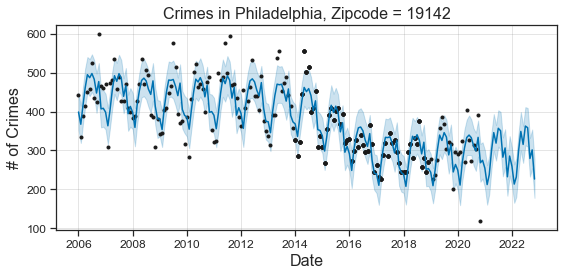

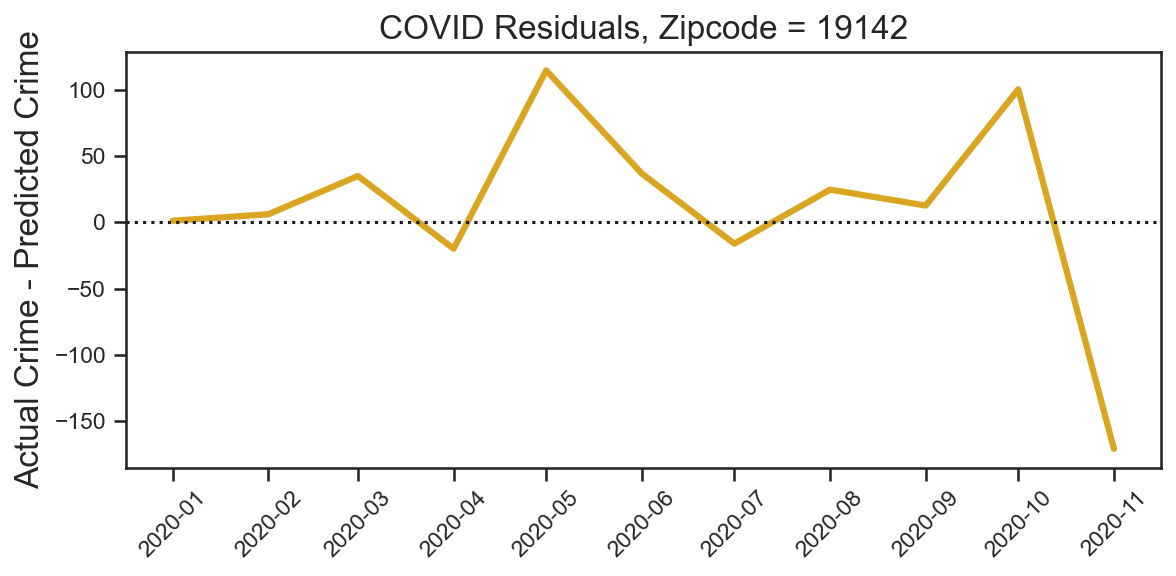

<Figure size 900x600 with 0 Axes>

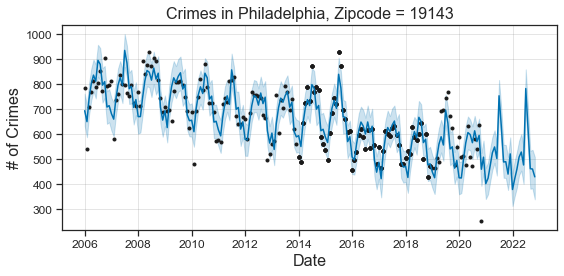

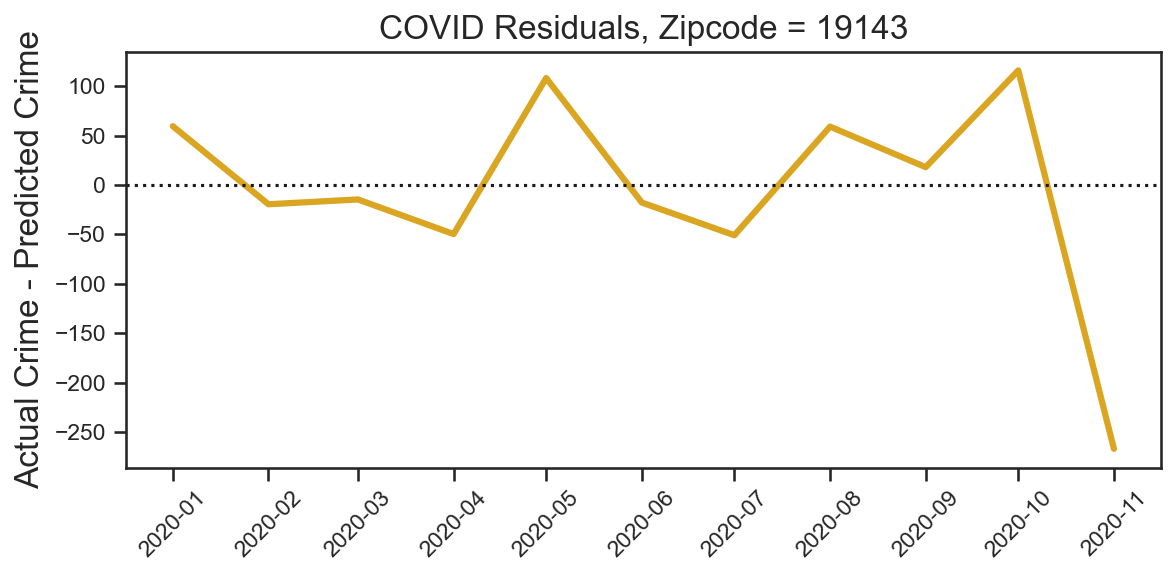

<Figure size 900x600 with 0 Axes>

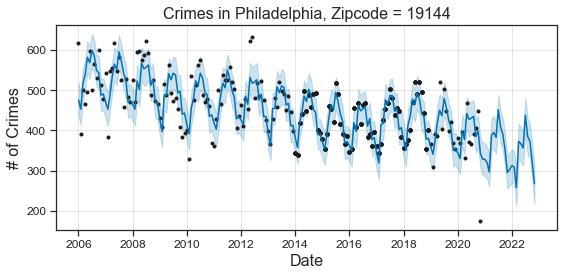

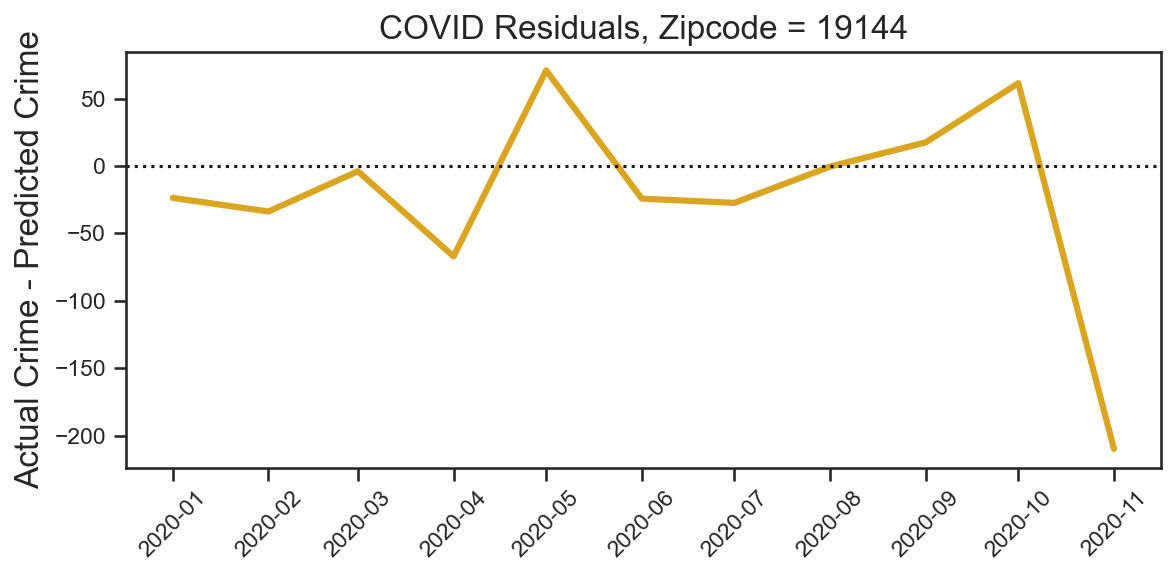

<Figure size 900x600 with 0 Axes>

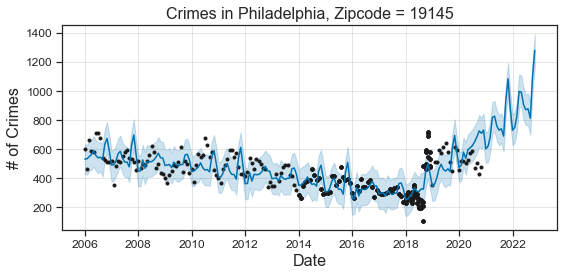

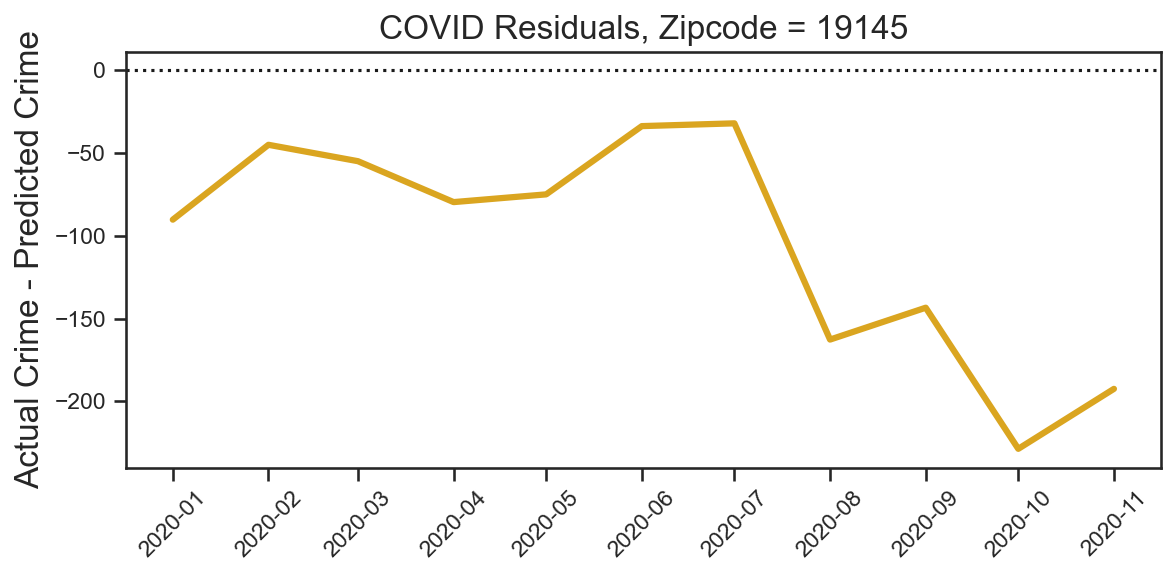

<Figure size 900x600 with 0 Axes>

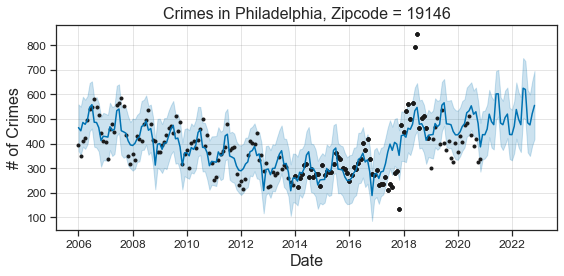

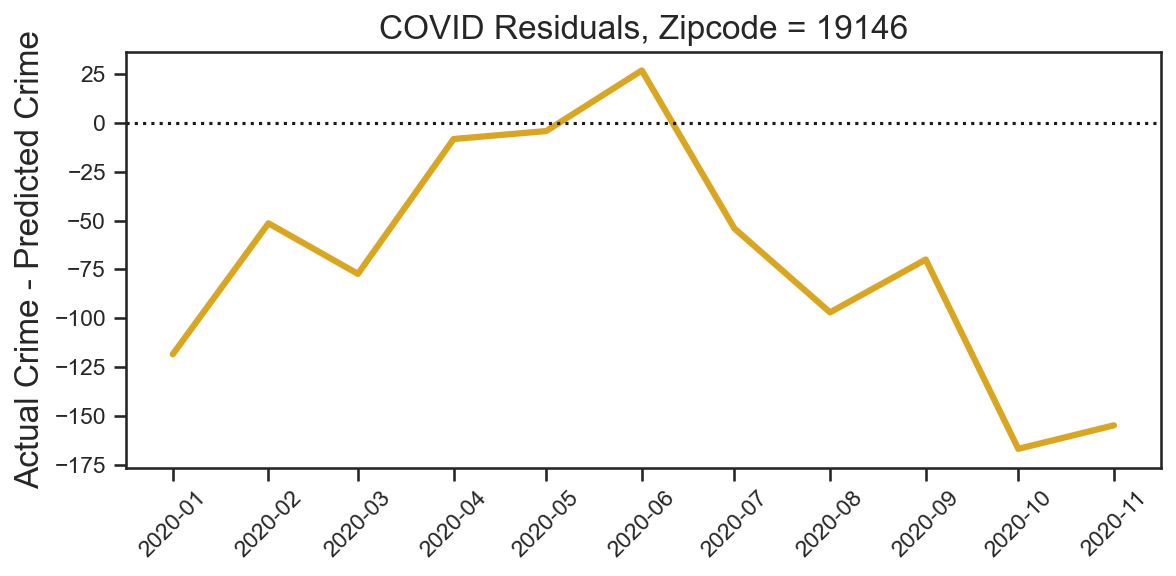

<Figure size 900x600 with 0 Axes>

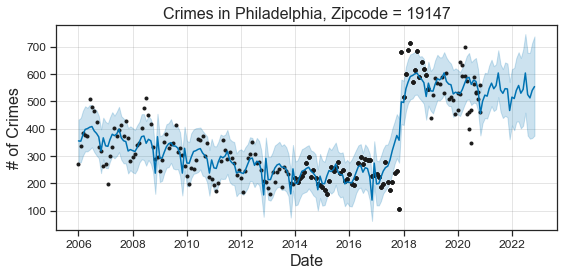

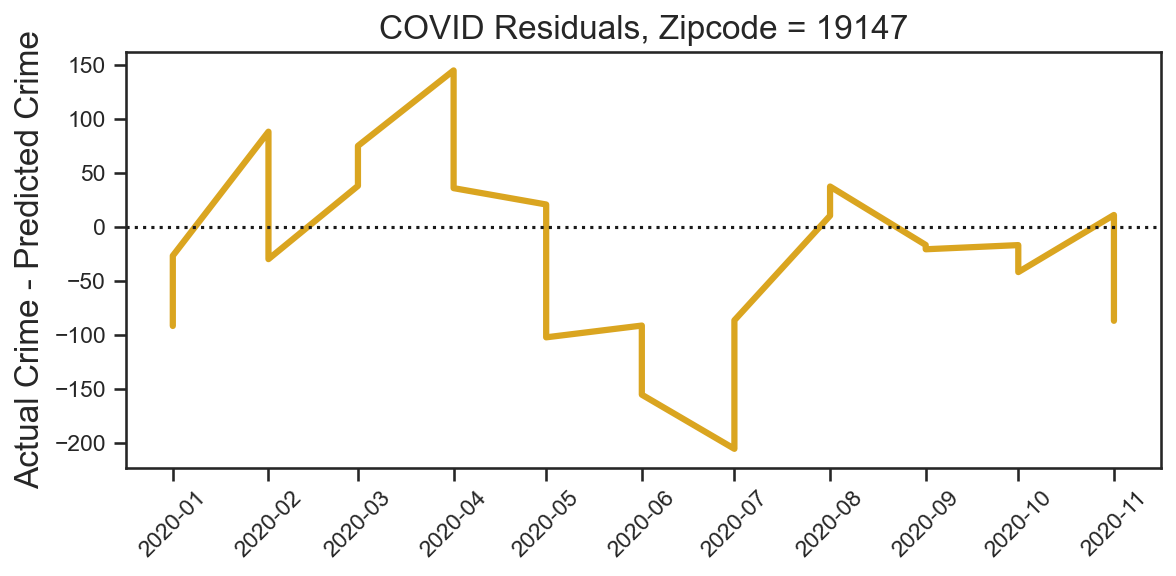

<Figure size 900x600 with 0 Axes>

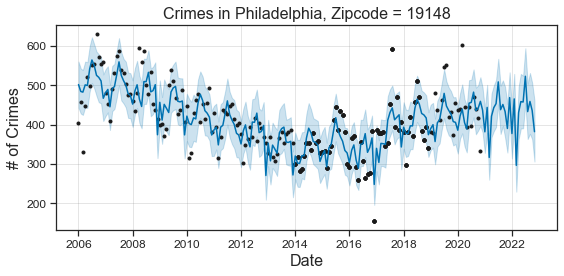

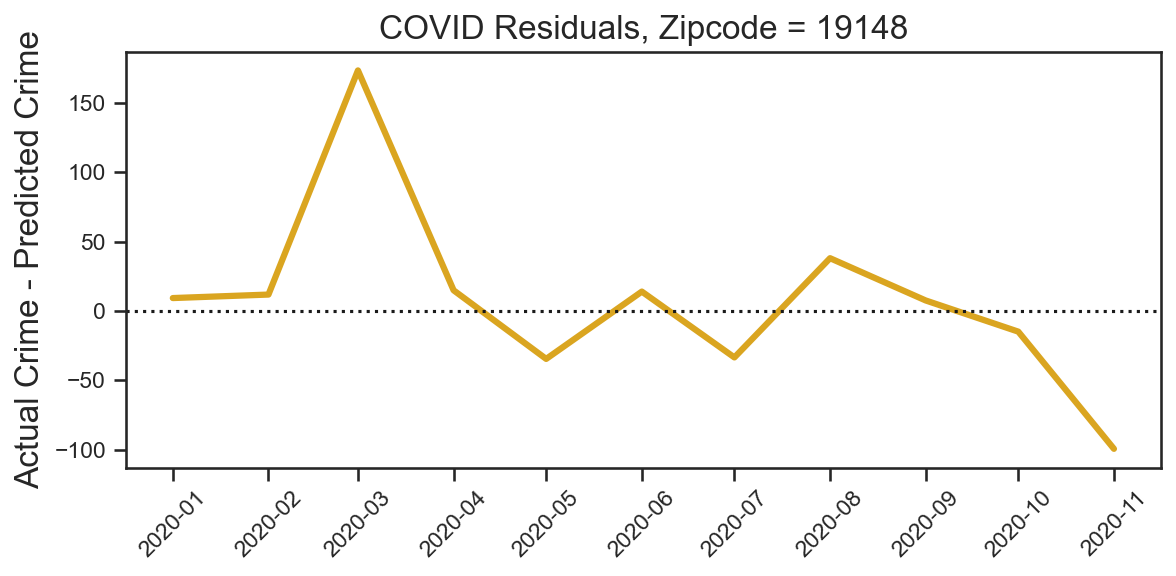

<Figure size 900x600 with 0 Axes>

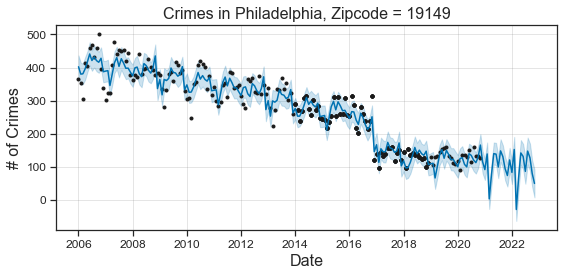

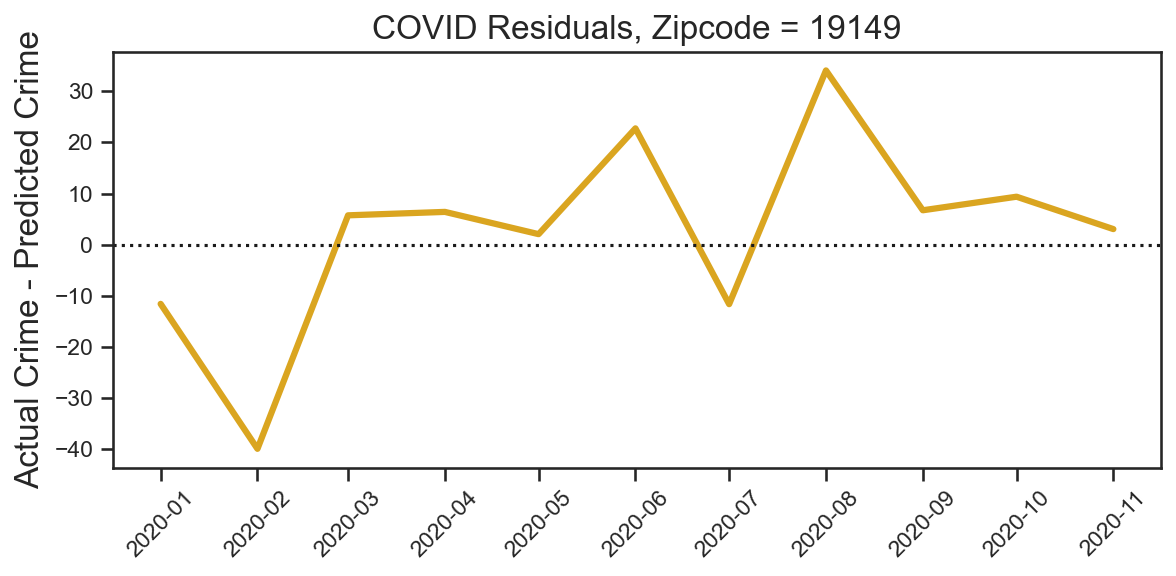

<Figure size 900x600 with 0 Axes>

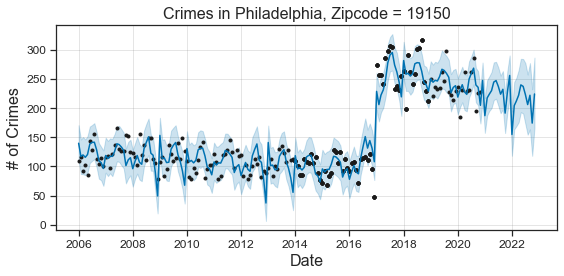

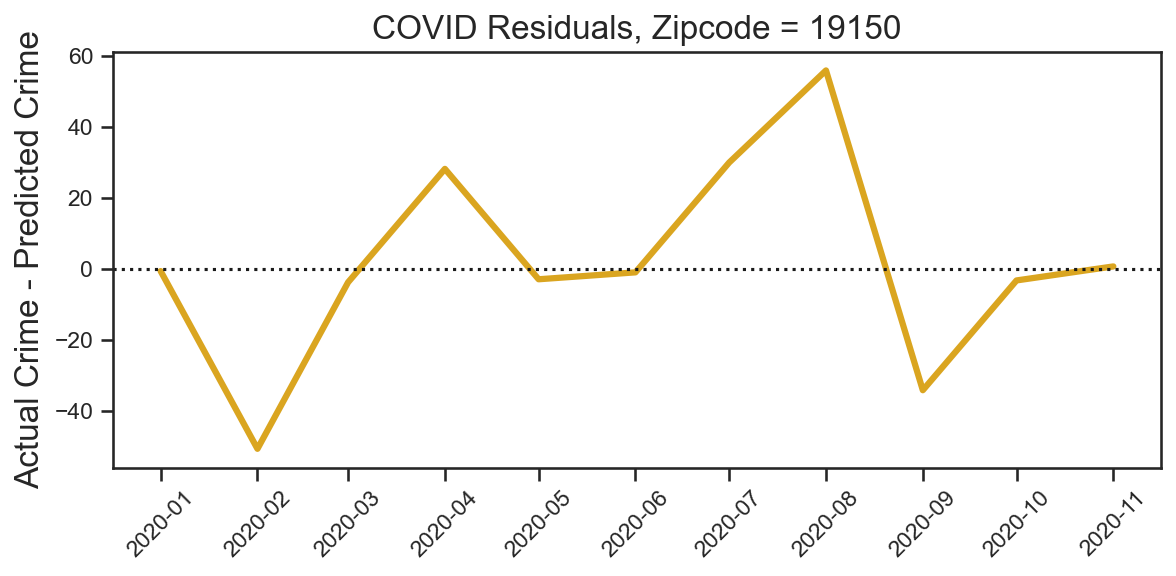

<Figure size 900x600 with 0 Axes>

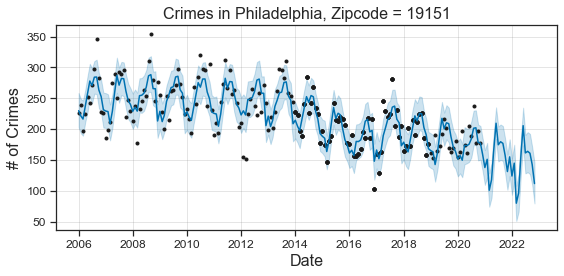

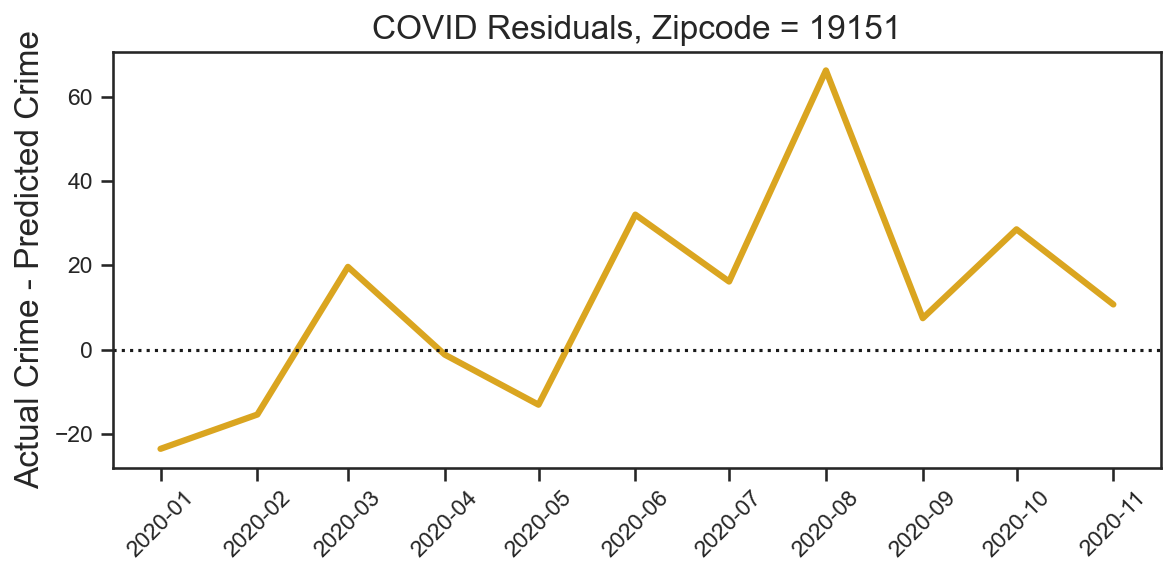

<Figure size 900x600 with 0 Axes>

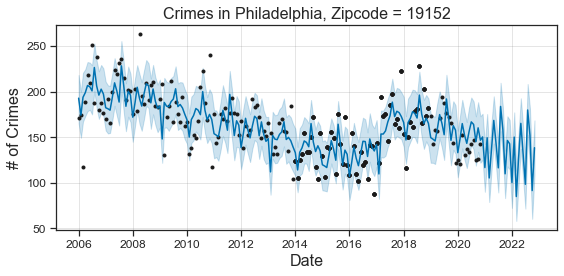

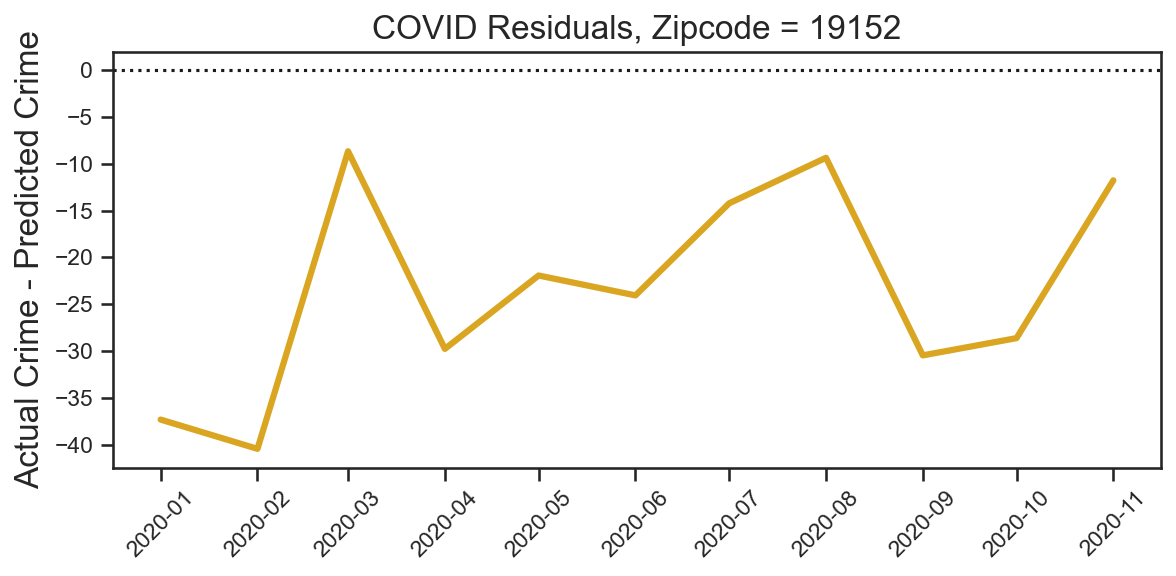

<Figure size 900x600 with 0 Axes>

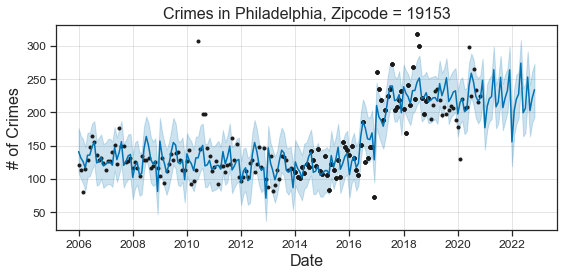

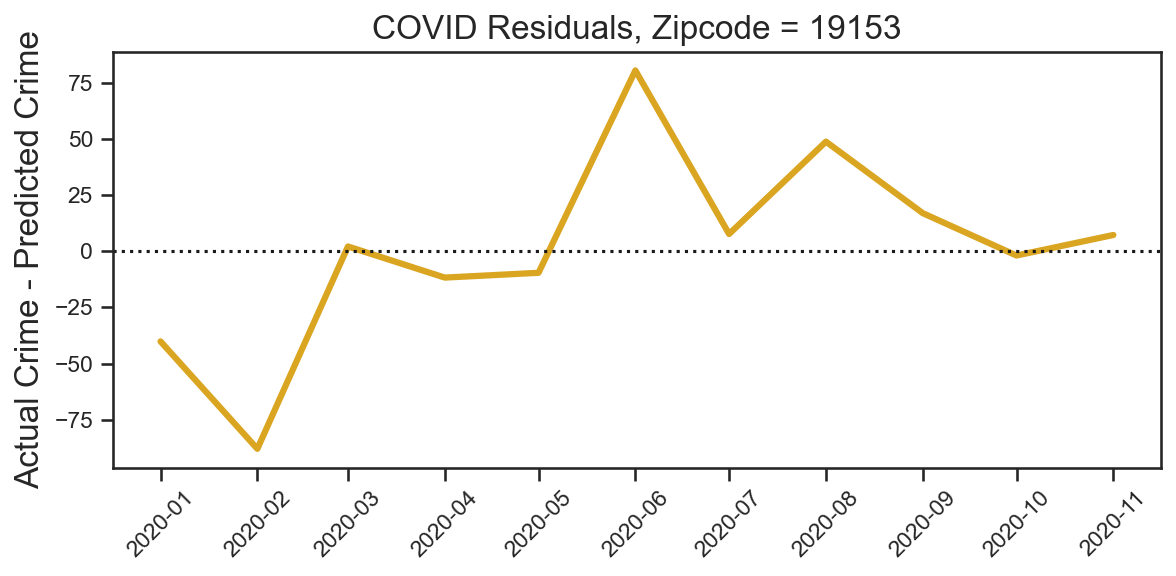

<Figure size 900x600 with 0 Axes>

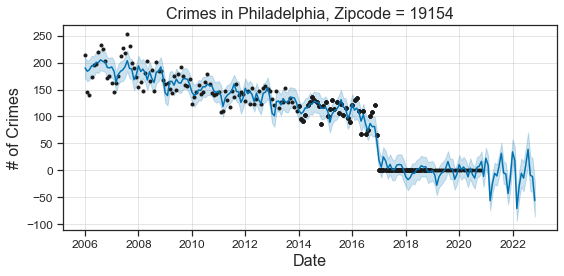

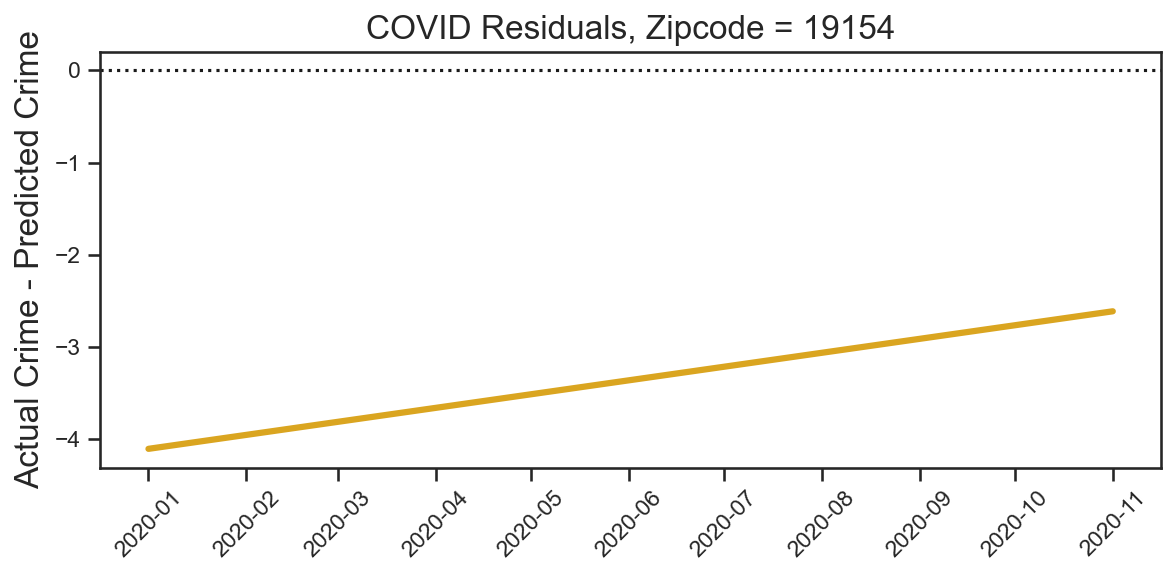

In [74]:
for i in np.arange(len(zipcodes)):
    crime = df[df.zipcode==zipcodes[i]][['dispatch_date','num_crimes']]
    crime = crime.rename(columns={'dispatch_date':'ds','num_crimes':'y'})

    crime_prophet = fbprophet.Prophet(changepoint_prior_scale=0.2)
    crime_prophet.fit(crime[~crime.isna()])

    crime_forecast = crime_prophet.make_future_dataframe(periods=12 * 2, freq='M')
    crime_forecast = crime_prophet.predict(crime_forecast)

    plt.figure(dpi=150)
    plot(crime_prophet, crime_forecast, figsize=(8, 4))
    #crime_prophet.plot(crime_forecast, xlabel = 'Date', ylabel = '# of Crimes',dpi=150)
    plt.title('Crimes in Philadelphia, Zipcode = '+str(zipcodes[i]),fontsize=16)
    plt.xlabel('Date',fontsize=16)
    plt.ylabel('# of Crimes',fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig('../images/crime/forecasting/model'+str(zipcodes[i])+'.png',bbox_inches='tight')

    forc = crime_forecast[crime_forecast.ds.dt.year==2020].merge(crime,on='ds')
    plt.figure(dpi=150,figsize=(8, 4))
    plt.plot(forc.ds, forc.y-forc.trend,lw=3,color='goldenrod')
    plt.axhline(y=0,c='k',ls=':')
    plt.xticks(rotation=45)
    plt.ylabel('Actual Crime - Predicted Crime',fontsize=16)
    plt.title('COVID Residuals, Zipcode = '+str(zipcodes[i]),fontsize=16)
    plt.tight_layout()
    plt.savefig('../images/crime/forecasting/COVID_residuals'+str(zipcodes[i])+'.png',bbox_inches='tight')

Text(0.5, 1.0, 'COVID Residuals, Zipcode = 19102')

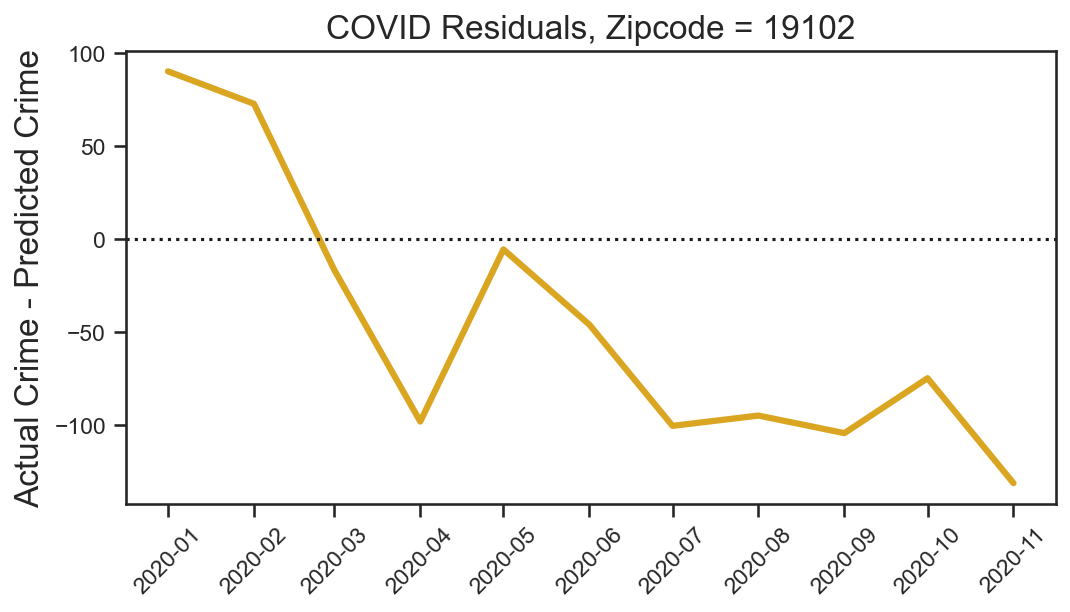

In [69]:
forc = crime_forecast[crime_forecast.ds.dt.year==2020].merge(crime,on='ds')
plt.figure(dpi=150)
plt.plot(forc.ds, forc.y-forc.trend,lw=3,color='goldenrod')
plt.axhline(y=0,c='k',ls=':')
plt.xticks(rotation=45)
plt.ylabel('Actual Crime - Predicted Crime',fontsize=16)
plt.title('COVID Residuals, Zipcode = '+str(zipcodes[0]),fontsize=16)
plt.savefig('../images/crime/forecasting/COVID_residuals'+str(zipcodes[0])+'.png')

In [44]:
crime_forecast.ds.dt.year

0      2006
1      2006
2      2006
3      2006
4      2006
       ... 
198    2022
199    2022
200    2022
201    2022
202    2022
Name: ds, Length: 203, dtype: int64